In [1]:
import sys
sys.path.append('../code')
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
from numpy import polyfit
from numpy import polyval
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from scipy.interpolate import interp1d
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого
_, test_loader, train_loader_no_augumentation, valid_loader = cifar10_loader(batch_size=128, split_train_val=True,
                                                                             maxsize=10112*2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_num = 100
# epoch_num = 50
run_num = 5 # количество запусков эксперимента
# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '19' 

validate_every_epoch = 5 
# spline_mode = 'linear' #полиномом какой степени пользуемся, смотри функцию scipy.interpolate.interp1d
# spline_mode = 'quadratic'
# spline_mode = 'cubic'
# train_splines_every_epoch = 5 # каждые 5 эпох отслеживать траекторию гиперпараметров
train_splines_every_epoch = 2
# train_splines_every_epoch = 3
# train_splines_every_epoch = 10
# размер мини-эпохи в батчах, за которую у нас производится либо обучение спайлов, либо их использование
mini_epoch_size = 10 
start_beta = 0.9914
start_temp  = 6.5

In [11]:
def accuracy(student):
        student.eval()
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        student.train()
        return (correct/total).cpu().detach().numpy()

In [5]:
# запуск без дистилляции
for _ in range(run_num):
    internal_results = []
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())    
    crit = nn.CrossEntropyLoss()
    for e in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for x,y in tq:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()            
            loss = crit(student(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))        
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc})
            print (internal_results[-1])

    with open('../log/exp'+experiment_version+'_basic.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

current loss:1.559369683265686:   3%|▎         | 2/79 [00:00<00:04, 18.93it/s]

{'epoch': 0, 'test loss': 1.611395001411438, 'accuracy': 0.41200000047683716}


current loss:1.1569583415985107:   3%|▎         | 2/79 [00:00<00:04, 19.02it/s]

{'epoch': 4, 'test loss': 1.3503203392028809, 'accuracy': 0.5291000008583069}


current loss:0.9074713587760925:   3%|▎         | 2/79 [00:00<00:04, 16.04it/s]

{'epoch': 9, 'test loss': 1.3050793409347534, 'accuracy': 0.5464000105857849}


current loss:0.8449549674987793:  32%|███▏      | 25/79 [00:01<00:02, 20.20it/s]


KeyboardInterrupt: 

In [6]:
kl = nn.KLDivLoss(reduction='batchmean')
sm = nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = F.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [8]:
# Запуск --- с CNN-дистилляцией
# в качестве значений гиперпараметров ставим  start_beta, start_temp
logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    beta = start_beta
    temp = start_temp
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    crit = nn.CrossEntropyLoss()
    for e in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, (x,y) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device)            
            student.zero_grad()
            out = student(x)
            student_loss = crit(out, y)            
            distillation_loss = distill(out, batch_logits, temp)
            loss = (1-beta) * student_loss + beta*distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc})
            print (internal_results[-1])

            
    with open('../log/exp'+experiment_version+'_distill.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

NameError: name 'start_beta' is not defined

In [ ]:
# Запуск --- со случаными значениями гиперпараметров
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []
    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0), device=device), requires_grad=True)    
    h = [beta1, beta2, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
 
    
    for e in range(epoch_num): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, ((x,y)) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 
                                     'temp':float(10*F.sigmoid(h[2]).cpu().detach().numpy()),
                                     'beta1':float(F.sigmoid(h[0]).cpu().detach().numpy()),
                                     'beta2':float(F.sigmoid(h[1]).cpu().detach().numpy())})
            
            print (internal_results[-1])

            
    with open('../log/exp'+experiment_version+'_dist_h_rand.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

In [12]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-beta
crit = nn.CrossEntropyLoss()
# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 9.9+0.1
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss
# определяем функцию валидационную функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

hist = []
logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0), device=device), requires_grad=True)    
    h = [beta1, beta2, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
    # параметры Adam и функцию подсчета градиента 
    # взял из статьи по DARTS (выбор архитектуры сети градиентными методами)
    # там также используется оптимизация гиперпараметров
    optim2 = t.optim.SGD(h,  lr=10e4)   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    
    crit = t.nn.CrossEntropyLoss()

    for e in range(epoch_num): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        
        
        tq = tqdm.tqdm(zip(train_loader_no_augumentation, valid_loader))
        losses = []
        for batch_id, ((x,y), (v_x, v_y)) in enumerate(tq):
       
            x = x.to(device)
            y = y.to(device)            
                      
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            # если настала пора понаблюдать за траекторий гиперпараметров
          
            #print (batch_id, 'train mini')
            v_x = v_x.to(device)
            v_y = v_y.to(device)  
            optim2.zero_grad()            
            hyper_grad_calc.calc_gradients((x,y,batch_logits), (v_x, v_y))    
            t.nn.utils.clip_grad_value_(h, 1.0)
            for h_ in h:
                h_.grad = t.where(t.isnan(h_.grad), t.zeros_like(h_.grad), h_.grad)  

            optim2.step()                         
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
    
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            test_loss2 = []            
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss2.append(crit(student(x), y).detach().cpu().numpy())                 
            print (float(np.mean(test_loss2)))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 
                                     'temp':float(0.1+9.9*F.sigmoid(h[2]).cpu().detach().numpy()),
                                     'beta1':float(F.sigmoid(h[0]).cpu().detach().numpy()),
                                     'beta2':float(F.sigmoid(h[1]).cpu().detach().numpy())})
            
            print (internal_results[-1])

            
    with open('../log/exp'+experiment_version+'_dist_h_b2_optim.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

0it [00:00, ?it/s]/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-6-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:1.5430548191070557: : 79it [00:11,  7.07it/s]


1.5990225076675415


current loss:1.582444429397583: : 1it [00:00,  6.49it/s]

{'epoch': 0, 'test loss': 1.6013065576553345, 'accuracy': 0.4034999907016754, 'temp': 1.9151013866066935, 'beta1': 0.30762016773223877, 'beta2': 0.4149881899356842}


current loss:1.3639965057373047: : 79it [00:10,  7.43it/s]
current loss:1.2615175247192383: : 79it [00:10,  7.21it/s]
current loss:1.1850641965866089: : 79it [00:10,  7.36it/s]
current loss:1.1224710941314697: : 79it [00:10,  7.23it/s]


1.418761968612671


current loss:1.094420075416565: : 1it [00:00,  7.07it/s]

{'epoch': 4, 'test loss': 1.3993831872940063, 'accuracy': 0.5400999784469604, 'temp': 1.7106314301490786, 'beta1': 0.3218427002429962, 'beta2': 0.44574326276779175}


current loss:1.0833022594451904: : 79it [00:11,  7.00it/s]
current loss:1.0564815998077393: : 79it [00:11,  7.01it/s]
current loss:1.0383951663970947: : 79it [00:11,  6.87it/s]
current loss:1.0343931913375854: : 79it [00:11,  6.92it/s]
current loss:1.0228253602981567: : 79it [00:10,  7.19it/s]


1.485902190208435


current loss:0.9731482267379761: : 1it [00:00,  6.56it/s]

{'epoch': 9, 'test loss': 1.4887956380844116, 'accuracy': 0.5523999929428101, 'temp': 1.4603185787796975, 'beta1': 0.34702667593955994, 'beta2': 0.46748626232147217}


current loss:1.0183240175247192: : 79it [00:10,  7.41it/s]
current loss:1.0191981792449951: : 79it [00:11,  7.08it/s]
current loss:1.0286190509796143: : 79it [00:10,  7.44it/s]
current loss:1.0472878217697144: : 79it [00:10,  7.47it/s]
current loss:1.081879734992981: : 79it [00:10,  7.46it/s] 


1.5973167419433594


current loss:1.045412302017212: : 1it [00:00,  6.36it/s]

{'epoch': 14, 'test loss': 1.6038943529129028, 'accuracy': 0.5539000034332275, 'temp': 1.1172718711197378, 'beta1': 0.39648211002349854, 'beta2': 0.492845743894577}


current loss:1.1196620464324951: : 79it [00:10,  7.44it/s]
current loss:1.158512830734253: : 79it [00:10,  7.45it/s] 
current loss:1.244945764541626: : 79it [00:10,  7.43it/s] 
current loss:1.367027997970581: : 79it [00:10,  7.44it/s] 
current loss:1.6982917785644531: : 79it [00:10,  7.43it/s]


1.666001319885254


current loss:1.6312214136123657: : 1it [00:00,  6.40it/s]

{'epoch': 19, 'test loss': 1.6888412237167358, 'accuracy': 0.5559999942779541, 'temp': 0.6635227832943201, 'beta1': 0.49226146936416626, 'beta2': 0.5236283540725708}


current loss:2.352846384048462: : 79it [00:10,  7.40it/s] 
current loss:2.583136796951294: : 79it [00:10,  7.41it/s] 
current loss:4.770861625671387: : 79it [00:10,  7.44it/s] 
current loss:9.576204299926758: : 79it [00:10,  7.47it/s] 
current loss:17.95037841796875: : 79it [00:10,  7.51it/s] 


1.9742369651794434


current loss:15.601234436035156: : 1it [00:00,  7.06it/s]

{'epoch': 24, 'test loss': 1.9710627794265747, 'accuracy': 0.5013999938964844, 'temp': 0.13957176995463672, 'beta1': 0.8258747458457947, 'beta2': 0.5867706537246704}


current loss:24.531322479248047: : 79it [00:10,  7.47it/s]
current loss:28.65603256225586: : 79it [00:10,  7.49it/s] 
current loss:21.933246612548828: : 79it [00:10,  7.52it/s]
current loss:20.456899642944336: : 79it [00:10,  7.52it/s]
current loss:24.907434463500977: : 79it [00:10,  7.42it/s]


2.0165553092956543


current loss:20.17947769165039: : 1it [00:00,  6.44it/s]

{'epoch': 29, 'test loss': 2.014530897140503, 'accuracy': 0.5313000082969666, 'temp': 0.1048379778279923, 'beta1': 0.9604201316833496, 'beta2': 0.6701493859291077}


current loss:19.498193740844727: : 79it [00:10,  7.50it/s]
current loss:19.85041046142578: : 79it [00:10,  7.45it/s] 
current loss:18.987035751342773: : 79it [00:10,  7.49it/s]
current loss:19.011852264404297: : 79it [00:10,  7.50it/s]
current loss:17.287281036376953: : 79it [00:10,  7.49it/s]


1.7446314096450806


current loss:15.725385665893555: : 1it [00:00,  6.72it/s]

{'epoch': 34, 'test loss': 1.749725341796875, 'accuracy': 0.5616000294685364, 'temp': 0.10276867478969508, 'beta1': 0.9759431481361389, 'beta2': 0.7173798680305481}


current loss:15.963296890258789: : 79it [00:10,  7.48it/s]
current loss:16.422513961791992: : 79it [00:10,  7.45it/s]
current loss:17.04428482055664: : 79it [00:10,  7.46it/s] 
current loss:17.35871124267578: : 79it [00:10,  7.45it/s] 
current loss:16.282180786132812: : 79it [00:10,  7.47it/s]


1.6482057571411133


current loss:14.145600318908691: : 1it [00:00,  6.97it/s]

{'epoch': 39, 'test loss': 1.6415077447891235, 'accuracy': 0.5777000188827515, 'temp': 0.10186303816590225, 'beta1': 0.9831933975219727, 'beta2': 0.7494922876358032}


current loss:16.52421760559082: : 79it [00:10,  7.47it/s] 
current loss:15.513346672058105: : 79it [00:10,  7.44it/s]
current loss:15.2667236328125: : 79it [00:10,  7.46it/s]  
current loss:13.113080024719238: : 79it [00:10,  7.45it/s]
current loss:14.214001655578613: : 79it [00:10,  7.47it/s]


1.6419347524642944


current loss:15.379000663757324: : 1it [00:00,  7.02it/s]

{'epoch': 44, 'test loss': 1.64750337600708, 'accuracy': 0.5745999813079834, 'temp': 0.10140597493737005, 'beta1': 0.987065851688385, 'beta2': 0.7749366164207458}


current loss:12.532857894897461: : 79it [00:10,  7.46it/s]
current loss:15.10713005065918: : 79it [00:10,  7.45it/s] 
current loss:12.596063613891602: : 79it [00:10,  7.45it/s]
current loss:12.972027778625488: : 79it [00:10,  7.46it/s]
current loss:11.873838424682617: : 79it [00:10,  7.43it/s]


1.607006549835205


current loss:11.751191139221191: : 1it [00:00,  6.92it/s]

{'epoch': 49, 'test loss': 1.6079962253570557, 'accuracy': 0.5713000297546387, 'temp': 0.10125595940626227, 'beta1': 0.9883920550346375, 'beta2': 0.7899081110954285}


current loss:13.015996932983398: : 79it [00:10,  7.46it/s]
current loss:11.807867050170898: : 79it [00:10,  7.43it/s]
current loss:13.342435836791992: : 79it [00:10,  7.48it/s]
current loss:12.315014839172363: : 79it [00:10,  7.46it/s]
current loss:12.63365364074707: : 79it [00:10,  7.47it/s] 


1.576392412185669


current loss:13.102869033813477: : 1it [00:00,  6.84it/s]

{'epoch': 54, 'test loss': 1.5754966735839844, 'accuracy': 0.5855000019073486, 'temp': 0.10105853703571484, 'beta1': 0.990050196647644, 'beta2': 0.8032424449920654}


current loss:12.222709655761719: : 79it [00:10,  7.41it/s]
current loss:11.531633377075195: : 79it [00:10,  7.45it/s]
current loss:12.122363090515137: : 79it [00:10,  7.45it/s]
current loss:10.920931816101074: : 79it [00:10,  7.47it/s]
current loss:11.300008773803711: : 79it [00:10,  7.47it/s]


1.4968452453613281


current loss:12.255685806274414: : 1it [00:00,  7.02it/s]

{'epoch': 59, 'test loss': 1.5062144994735718, 'accuracy': 0.5860000252723694, 'temp': 0.10095005492839847, 'beta1': 0.9909951090812683, 'beta2': 0.8146902322769165}


current loss:11.510298728942871: : 79it [00:10,  7.46it/s]
current loss:11.685715675354004: : 79it [00:10,  7.44it/s]
current loss:10.041725158691406: : 79it [00:10,  7.47it/s]
current loss:9.71565055847168: : 79it [00:10,  7.45it/s]  
current loss:9.878968238830566: : 79it [00:10,  7.44it/s] 


1.4979792833328247


current loss:11.937623023986816: : 1it [00:00,  7.03it/s]

{'epoch': 64, 'test loss': 1.4970173835754395, 'accuracy': 0.5848000049591064, 'temp': 0.10084653207886732, 'beta1': 0.9919112324714661, 'beta2': 0.8237298727035522}


current loss:10.012539863586426: : 79it [00:10,  7.45it/s]
current loss:9.420552253723145: : 79it [00:10,  7.45it/s] 
current loss:9.286385536193848: : 79it [00:10,  7.44it/s] 
current loss:9.350576400756836: : 79it [00:10,  7.45it/s] 
current loss:8.870144844055176: : 79it [00:10,  7.46it/s] 


1.4799705743789673


current loss:11.452764511108398: : 1it [00:00,  6.97it/s]

{'epoch': 69, 'test loss': 1.4842153787612915, 'accuracy': 0.5914999842643738, 'temp': 0.10079888738982845, 'beta1': 0.992352306842804, 'beta2': 0.8305813074111938}


current loss:9.352653503417969: : 79it [00:10,  7.35it/s] 
current loss:9.923942565917969: : 79it [00:10,  7.38it/s] 
current loss:9.2036771774292: : 79it [00:10,  7.44it/s]   
current loss:9.860086441040039: : 79it [00:10,  7.21it/s] 
current loss:9.921635627746582: : 79it [00:10,  7.43it/s] 


1.4651570320129395


current loss:8.629603385925293: : 1it [00:00,  6.72it/s]

{'epoch': 74, 'test loss': 1.454132318496704, 'accuracy': 0.5895000100135803, 'temp': 0.10077545329768328, 'beta1': 0.9926869869232178, 'beta2': 0.8356616497039795}


current loss:10.148979187011719: : 79it [00:10,  7.42it/s]
current loss:9.397294998168945: : 79it [00:10,  7.44it/s] 
current loss:8.64653205871582: : 79it [00:10,  7.46it/s]  
current loss:8.760333061218262: : 79it [00:10,  7.46it/s] 
current loss:8.342073440551758: : 79it [00:10,  7.47it/s] 


1.4114265441894531


current loss:8.930383682250977: : 1it [00:00,  6.92it/s]

{'epoch': 79, 'test loss': 1.4026798009872437, 'accuracy': 0.5974000096321106, 'temp': 0.10072837989428081, 'beta1': 0.99309903383255, 'beta2': 0.8395196795463562}


current loss:8.293363571166992: : 79it [00:10,  7.43it/s] 
current loss:8.249855995178223: : 79it [00:10,  7.42it/s] 
current loss:8.091041564941406: : 79it [00:10,  7.46it/s] 
current loss:8.082602500915527: : 79it [00:10,  7.46it/s] 
current loss:7.651412010192871: : 79it [00:10,  7.46it/s] 


1.3994789123535156


current loss:8.573055267333984: : 1it [00:00,  6.93it/s]

{'epoch': 84, 'test loss': 1.3927446603775024, 'accuracy': 0.5950000286102295, 'temp': 0.10068005817665836, 'beta1': 0.9935429096221924, 'beta2': 0.8442494869232178}


current loss:7.933279991149902: : 79it [00:10,  7.42it/s] 
current loss:8.335079193115234: : 79it [00:10,  7.42it/s] 
current loss:7.364075660705566: : 79it [00:10,  7.46it/s] 
current loss:8.191967010498047: : 79it [00:10,  7.46it/s] 
current loss:7.5772809982299805: : 79it [00:10,  7.47it/s]


1.3965530395507812


current loss:8.77503776550293: : 1it [00:00,  6.97it/s]

{'epoch': 89, 'test loss': 1.407371163368225, 'accuracy': 0.5971999764442444, 'temp': 0.10063656922866358, 'beta1': 0.993924081325531, 'beta2': 0.8495307564735413}


current loss:8.702371597290039: : 79it [00:10,  7.45it/s] 
current loss:7.568565368652344: : 79it [00:10,  7.39it/s] 
current loss:7.463631629943848: : 79it [00:10,  7.48it/s] 
current loss:7.5574235916137695: : 79it [00:10,  7.43it/s]
current loss:7.702226161956787: : 79it [00:10,  7.46it/s] 


1.3884223699569702


current loss:7.581021308898926: : 1it [00:00,  6.95it/s]

{'epoch': 94, 'test loss': 1.3929619789123535, 'accuracy': 0.5996000170707703, 'temp': 0.10059096448530909, 'beta1': 0.9943711161613464, 'beta2': 0.8547242283821106}


current loss:6.927098751068115: : 79it [00:10,  7.43it/s] 
current loss:6.733935356140137: : 79it [00:10,  7.46it/s] 
current loss:6.875085353851318: : 79it [00:10,  7.45it/s] 
current loss:7.617554664611816: : 79it [00:10,  7.47it/s] 
current loss:6.876309394836426: : 79it [00:10,  7.43it/s] 


1.3990851640701294


current loss:1.4183735847473145: : 1it [00:00,  7.04it/s]

{'epoch': 99, 'test loss': 1.401751160621643, 'accuracy': 0.600600004196167, 'temp': 0.10055388789623976, 'beta1': 0.9947130084037781, 'beta2': 0.8587031960487366}


current loss:1.0689833164215088: : 79it [00:10,  7.46it/s]


1.6292786598205566


current loss:1.076575517654419: : 1it [00:00,  6.88it/s]

{'epoch': 0, 'test loss': 1.6306955814361572, 'accuracy': 0.39149999618530273, 'temp': 3.9741136342287064, 'beta1': 0.5320974588394165, 'beta2': 0.33021748065948486}


current loss:0.9676805734634399: : 79it [00:10,  7.45it/s]
current loss:0.8990548849105835: : 79it [00:10,  7.43it/s]
current loss:0.8447230458259583: : 79it [00:10,  7.43it/s]
current loss:0.812451183795929: : 79it [00:10,  7.47it/s] 


1.4262566566467285


current loss:0.7807353734970093: : 1it [00:00,  7.00it/s]

{'epoch': 4, 'test loss': 1.4235180616378784, 'accuracy': 0.5167999863624573, 'temp': 3.866082757711411, 'beta1': 0.5364737510681152, 'beta2': 0.3562454879283905}


current loss:0.7848268151283264: : 79it [00:10,  7.44it/s]
current loss:0.7685085535049438: : 79it [00:10,  7.47it/s]
current loss:0.7540596723556519: : 79it [00:10,  7.46it/s]
current loss:0.7474923729896545: : 79it [00:10,  7.43it/s]
current loss:0.7393690347671509: : 79it [00:10,  7.47it/s]


1.4556916952133179


current loss:0.7087574601173401: : 1it [00:00,  6.87it/s]

{'epoch': 9, 'test loss': 1.451886534690857, 'accuracy': 0.5533000230789185, 'temp': 3.645230096578598, 'beta1': 0.5452995896339417, 'beta2': 0.3862174153327942}


current loss:0.7332260608673096: : 79it [00:10,  7.44it/s]
current loss:0.7297073006629944: : 79it [00:10,  7.45it/s]
current loss:0.7188568711280823: : 79it [00:10,  7.46it/s]
current loss:0.7130496501922607: : 79it [00:10,  7.44it/s]
current loss:0.7063714861869812: : 79it [00:10,  7.45it/s]


1.5444674491882324


current loss:0.6889184713363647: : 1it [00:00,  6.95it/s]

{'epoch': 14, 'test loss': 1.5562485456466675, 'accuracy': 0.5611000061035156, 'temp': 3.4293261915445328, 'beta1': 0.5538718104362488, 'beta2': 0.4123646914958954}


current loss:0.700594961643219: : 79it [00:10,  7.43it/s] 
current loss:0.696902871131897: : 79it [00:10,  7.46it/s] 
current loss:0.6950310468673706: : 79it [00:10,  7.45it/s]
current loss:0.6909512281417847: : 79it [00:10,  7.45it/s]
current loss:0.6898165345191956: : 79it [00:10,  7.18it/s]


1.6596928834915161


current loss:0.6624326705932617: : 1it [00:00,  7.03it/s]

{'epoch': 19, 'test loss': 1.666825532913208, 'accuracy': 0.5625, 'temp': 3.2087532311677935, 'beta1': 0.5628461837768555, 'beta2': 0.43375664949417114}


current loss:0.6906630396842957: : 79it [30:08, 22.89s/it] 
current loss:0.689250111579895: : 79it [00:22,  3.58it/s] 
current loss:0.6940903663635254: : 79it [42:56, 32.61s/it] 
current loss:0.7053297162055969: : 79it [00:13,  5.65it/s]
current loss:0.717785120010376: : 79it [00:29,  2.70it/s] 


1.8141647577285767


current loss:0.6671284437179565: : 1it [00:00,  7.14it/s]

{'epoch': 24, 'test loss': 1.8220374584197998, 'accuracy': 0.555899977684021, 'temp': 2.965973269939423, 'beta1': 0.5730776190757751, 'beta2': 0.4547000825405121}


current loss:0.7303212285041809: : 79it [00:18,  4.38it/s]
current loss:0.7423999309539795: : 79it [00:26,  2.98it/s]
current loss:0.7459582090377808: : 79it [1:01:32, 46.74s/it] 
current loss:0.7384980916976929: : 79it [00:10,  7.39it/s]
current loss:0.7325519919395447: : 79it [00:10,  7.36it/s]


2.0564703941345215


current loss:0.6663204431533813: : 1it [00:00,  7.12it/s]

{'epoch': 29, 'test loss': 2.057997941970825, 'accuracy': 0.5396999716758728, 'temp': 2.6785594999790194, 'beta1': 0.5853158235549927, 'beta2': 0.47783926129341125}


current loss:0.7303893566131592: : 79it [00:10,  7.31it/s]
current loss:0.7245942950248718: : 79it [00:10,  7.50it/s]
current loss:0.7196558117866516: : 79it [00:10,  7.36it/s]
current loss:0.7191613912582397: : 79it [00:10,  7.45it/s]
current loss:0.7173985242843628: : 79it [23:02, 17.50s/it] 


2.071099281311035


current loss:0.6071681976318359: : 1it [00:00,  7.08it/s]

{'epoch': 34, 'test loss': 2.0945286750793457, 'accuracy': 0.5498999953269958, 'temp': 2.460679692029953, 'beta1': 0.5948098301887512, 'beta2': 0.4943440854549408}


current loss:0.7165341377258301: : 79it [15:56, 12.11s/it] 
current loss:0.7135071754455566: : 79it [00:13,  5.68it/s]
current loss:0.711501955986023: : 79it [00:26,  3.01it/s] 
current loss:0.7072606682777405: : 79it [2:00:10, 91.28s/it]  
current loss:0.7043979167938232: : 79it [00:21,  3.66it/s]


2.1739108562469482


0it [00:00, ?it/s]

{'epoch': 39, 'test loss': 2.187650203704834, 'accuracy': 0.5493999719619751, 'temp': 2.28214593231678, 'beta1': 0.6029440760612488, 'beta2': 0.5110191702842712}


current loss:0.7027134895324707: : 79it [1:02:25, 47.41s/it]  
current loss:0.7002198100090027: : 79it [00:23,  3.33it/s]
current loss:0.6934187412261963: : 79it [47:37, 36.18s/it] 
current loss:0.6932721138000488: : 79it [00:11,  7.12it/s]
current loss:0.6889176964759827: : 79it [00:10,  7.49it/s]


2.267353057861328


current loss:0.6584908962249756: : 1it [00:00,  6.98it/s]

{'epoch': 44, 'test loss': 2.241943597793579, 'accuracy': 0.5557000041007996, 'temp': 2.123666687309742, 'beta1': 0.6103875041007996, 'beta2': 0.5249381065368652}


current loss:0.692609965801239: : 79it [00:10,  7.50it/s] 
current loss:0.6941810846328735: : 79it [00:11,  7.14it/s]
current loss:0.6992853879928589: : 79it [00:11,  7.02it/s]
current loss:0.7005325555801392: : 79it [00:11,  7.16it/s]
current loss:0.7020031213760376: : 79it [00:10,  7.34it/s]


2.2981338500976562


current loss:0.6926348209381104: : 1it [00:00,  6.58it/s]

{'epoch': 49, 'test loss': 2.3003296852111816, 'accuracy': 0.5593000054359436, 'temp': 1.9227313458919526, 'beta1': 0.6202634572982788, 'beta2': 0.5403873324394226}


current loss:0.7022276520729065: : 79it [00:10,  7.45it/s]
current loss:0.6976233124732971: : 79it [00:10,  7.44it/s]
current loss:0.7045784592628479: : 79it [00:10,  7.41it/s]
current loss:0.6982624530792236: : 79it [00:10,  7.42it/s]
current loss:0.7004536390304565: : 79it [00:10,  7.44it/s]


2.3914101123809814


current loss:0.6576474905014038: : 1it [00:00,  6.96it/s]

{'epoch': 54, 'test loss': 2.397509813308716, 'accuracy': 0.5636000037193298, 'temp': 1.750411781668663, 'beta1': 0.6295651197433472, 'beta2': 0.5516550540924072}


current loss:0.698253870010376: : 79it [00:10,  7.45it/s] 
current loss:0.7031686902046204: : 79it [00:10,  7.46it/s]
current loss:0.7257983684539795: : 79it [00:10,  7.32it/s]
current loss:0.734356164932251: : 79it [00:10,  7.41it/s] 
current loss:0.7422690391540527: : 79it [00:11,  7.14it/s]


2.453202724456787


current loss:0.6937947273254395: : 1it [00:00,  6.70it/s]

{'epoch': 59, 'test loss': 2.4487435817718506, 'accuracy': 0.5616999864578247, 'temp': 1.5830744609236718, 'beta1': 0.641578197479248, 'beta2': 0.5655274391174316}


current loss:0.7590283155441284: : 79it [00:11,  7.18it/s]
current loss:0.7991184592247009: : 79it [00:11,  7.05it/s]
current loss:0.8054364919662476: : 79it [00:10,  7.34it/s]
current loss:0.8033599853515625: : 79it [00:10,  7.42it/s]
current loss:0.8459306955337524: : 79it [00:10,  7.43it/s]


2.444319248199463


current loss:0.7476484775543213: : 1it [00:00,  6.82it/s]

{'epoch': 64, 'test loss': 2.4513940811157227, 'accuracy': 0.5618000030517578, 'temp': 1.3644358024001122, 'beta1': 0.6576606631278992, 'beta2': 0.5813291668891907}


current loss:0.8727768659591675: : 79it [00:10,  7.38it/s]
current loss:0.8906759023666382: : 79it [00:10,  7.33it/s]
current loss:0.8635198473930359: : 79it [00:10,  7.36it/s]
current loss:0.8305405378341675: : 79it [00:10,  7.41it/s]
current loss:0.8264546394348145: : 79it [00:10,  7.40it/s]


2.524658441543579


current loss:0.720359206199646: : 1it [00:00,  6.68it/s]

{'epoch': 69, 'test loss': 2.5052549839019775, 'accuracy': 0.5633999705314636, 'temp': 1.165083145350218, 'beta1': 0.6743232011795044, 'beta2': 0.5954076647758484}


current loss:0.875693678855896: : 79it [00:10,  7.33it/s] 
current loss:0.9185565114021301: : 79it [00:10,  7.38it/s]
current loss:0.915310263633728: : 79it [00:10,  7.39it/s] 
current loss:0.8731045722961426: : 79it [00:10,  7.38it/s]
current loss:0.8768838047981262: : 79it [00:10,  7.42it/s]


2.6806650161743164


current loss:0.7439634799957275: : 1it [00:00,  6.65it/s]

{'epoch': 74, 'test loss': 2.6513664722442627, 'accuracy': 0.5577999949455261, 'temp': 1.0252153597772122, 'beta1': 0.6890794038772583, 'beta2': 0.6083592772483826}


current loss:0.8521713018417358: : 79it [00:10,  7.36it/s]
current loss:0.9083572626113892: : 79it [00:10,  7.29it/s]
current loss:0.9110371470451355: : 79it [00:11,  7.12it/s]
current loss:0.9463754892349243: : 79it [00:11,  7.06it/s]
current loss:0.9790358543395996: : 79it [00:12,  6.52it/s]


2.5782523155212402


current loss:0.7301623821258545: : 1it [00:00,  6.29it/s]

{'epoch': 79, 'test loss': 2.604935646057129, 'accuracy': 0.5615000128746033, 'temp': 0.9096670091152191, 'beta1': 0.7026757597923279, 'beta2': 0.6169604659080505}


current loss:0.9641693234443665: : 79it [00:11,  7.09it/s]
current loss:0.95685213804245: : 79it [00:11,  6.96it/s]  
current loss:0.9395917057991028: : 79it [00:11,  7.11it/s]
current loss:0.9278091192245483: : 79it [00:10,  7.27it/s]
current loss:0.9287256002426147: : 79it [00:10,  7.32it/s]


2.6380369663238525


current loss:0.6382923126220703: : 1it [00:00,  6.61it/s]

{'epoch': 84, 'test loss': 2.637460231781006, 'accuracy': 0.555400013923645, 'temp': 0.8146213434636593, 'beta1': 0.7142586708068848, 'beta2': 0.6256951093673706}


current loss:0.9236122369766235: : 79it [00:10,  7.33it/s]
current loss:0.9850274920463562: : 79it [00:10,  7.37it/s]
current loss:0.9808133840560913: : 79it [00:11,  7.11it/s]
current loss:0.9654864072799683: : 79it [00:10,  7.44it/s]
current loss:0.9387838244438171: : 79it [00:10,  7.44it/s]


2.586390495300293


current loss:0.8658254742622375: : 1it [00:00,  5.40it/s]

{'epoch': 89, 'test loss': 2.594106674194336, 'accuracy': 0.564300000667572, 'temp': 0.7033693719655275, 'beta1': 0.728205144405365, 'beta2': 0.6322290897369385}


current loss:1.0359660387039185: : 79it [00:10,  7.41it/s]
current loss:1.0336166620254517: : 79it [00:10,  7.44it/s]
current loss:1.2570780515670776: : 79it [00:10,  7.41it/s]
current loss:1.302767038345337: : 79it [00:10,  7.48it/s] 
current loss:1.298753023147583: : 79it [00:10,  7.39it/s] 


2.7044436931610107


current loss:1.1209120750427246: : 1it [00:00,  6.82it/s]

{'epoch': 94, 'test loss': 2.6611218452453613, 'accuracy': 0.5580999851226807, 'temp': 0.567721401900053, 'beta1': 0.7479085326194763, 'beta2': 0.6431311368942261}


current loss:1.238003134727478: : 79it [00:10,  7.36it/s] 
current loss:1.3903272151947021: : 79it [00:10,  7.29it/s]
current loss:1.477128267288208: : 79it [00:10,  7.31it/s] 
current loss:1.4712949991226196: : 79it [00:10,  7.39it/s]
current loss:1.7956724166870117: : 79it [00:10,  7.41it/s]


2.66914963722229


current loss:1.8077011108398438: : 1it [00:00,  7.00it/s]

{'epoch': 99, 'test loss': 2.6648404598236084, 'accuracy': 0.5590000152587891, 'temp': 0.43093025088310244, 'beta1': 0.770258367061615, 'beta2': 0.6520038843154907}


current loss:1.345504879951477: : 79it [00:10,  7.42it/s] 


1.6180146932601929


current loss:1.371236801147461: : 1it [00:00,  7.01it/s]

{'epoch': 0, 'test loss': 1.6170306205749512, 'accuracy': 0.39640000462532043, 'temp': 3.119432801008225, 'beta1': 0.5018082857131958, 'beta2': 0.3721749782562256}


current loss:1.2106987237930298: : 79it [00:10,  7.39it/s]
current loss:1.0988237857818604: : 79it [00:10,  7.45it/s]
current loss:1.029063105583191: : 79it [00:10,  7.43it/s] 
current loss:0.9969439506530762: : 79it [00:10,  7.42it/s]


1.4121859073638916


current loss:0.9771563410758972: : 1it [00:00,  7.04it/s]

{'epoch': 4, 'test loss': 1.410436987876892, 'accuracy': 0.5284000039100647, 'temp': 2.93423313498497, 'beta1': 0.5102662444114685, 'beta2': 0.3996388912200928}


current loss:0.9769082069396973: : 79it [00:10,  7.43it/s]
current loss:0.9677556753158569: : 79it [00:10,  7.35it/s]
current loss:0.9659164547920227: : 79it [00:10,  7.29it/s]
current loss:0.9621895551681519: : 79it [00:10,  7.43it/s]
current loss:0.9498919248580933: : 79it [00:10,  7.45it/s]


1.4850280284881592


current loss:0.9019080996513367: : 1it [00:00,  6.97it/s]

{'epoch': 9, 'test loss': 1.4906249046325684, 'accuracy': 0.5511000156402588, 'temp': 2.6060883849859238, 'beta1': 0.5254839062690735, 'beta2': 0.43335336446762085}


current loss:0.9398835301399231: : 79it [00:10,  7.41it/s]
current loss:0.9295884370803833: : 79it [00:10,  7.46it/s]
current loss:0.9196816682815552: : 79it [00:10,  7.37it/s]
current loss:0.9076865315437317: : 79it [00:10,  7.47it/s]
current loss:0.894553542137146: : 79it [00:10,  7.40it/s] 


1.576292872428894


current loss:0.8621089458465576: : 1it [00:00,  7.01it/s]

{'epoch': 14, 'test loss': 1.5852073431015015, 'accuracy': 0.5559999942779541, 'temp': 2.424869439005852, 'beta1': 0.535660445690155, 'beta2': 0.4553929269313812}


current loss:0.8826743960380554: : 79it [00:10,  7.42it/s]
current loss:0.871302604675293: : 79it [00:10,  7.45it/s] 
current loss:0.8662956953048706: : 79it [00:10,  7.43it/s]
current loss:0.8600325584411621: : 79it [00:10,  7.42it/s]
current loss:0.855677604675293: : 79it [00:10,  7.32it/s] 


1.7242547273635864


current loss:0.8000015616416931: : 1it [00:00,  7.02it/s]

{'epoch': 19, 'test loss': 1.7154510021209717, 'accuracy': 0.5608000159263611, 'temp': 2.248702219128609, 'beta1': 0.5456533432006836, 'beta2': 0.47239068150520325}


current loss:0.8517613410949707: : 79it [00:10,  7.41it/s]
current loss:0.8542270660400391: : 79it [00:11,  7.05it/s]
current loss:0.8541970252990723: : 79it [00:10,  7.39it/s]
current loss:0.8575717806816101: : 79it [00:10,  7.44it/s]
current loss:0.8646526336669922: : 79it [00:10,  7.43it/s]


1.8282421827316284


current loss:0.7840887308120728: : 1it [00:00,  6.96it/s]

{'epoch': 24, 'test loss': 1.8430780172348022, 'accuracy': 0.5622000098228455, 'temp': 2.0243308752775193, 'beta1': 0.5599011182785034, 'beta2': 0.4906698763370514}


current loss:0.8659554719924927: : 79it [00:10,  7.44it/s]
current loss:0.8800159692764282: : 79it [00:10,  7.47it/s]
current loss:0.9015606045722961: : 79it [00:10,  7.47it/s]
current loss:0.915490448474884: : 79it [00:10,  7.46it/s] 
current loss:0.9335076212882996: : 79it [00:10,  7.48it/s]


1.8827400207519531


current loss:0.778823971748352: : 1it [00:00,  6.97it/s]

{'epoch': 29, 'test loss': 1.8819966316223145, 'accuracy': 0.5637999773025513, 'temp': 1.754604195058346, 'beta1': 0.5779584646224976, 'beta2': 0.5125320553779602}


current loss:0.9284764528274536: : 79it [00:10,  7.36it/s]
current loss:0.935066819190979: : 79it [00:10,  7.49it/s] 
current loss:0.9413501024246216: : 79it [00:10,  7.50it/s]
current loss:0.9644883871078491: : 79it [00:10,  7.45it/s]
current loss:0.9935935735702515: : 79it [00:10,  7.48it/s]


1.9808967113494873


current loss:0.8633847236633301: : 1it [00:00,  7.04it/s]

{'epoch': 34, 'test loss': 1.983021855354309, 'accuracy': 0.5608999729156494, 'temp': 1.4820201709866525, 'beta1': 0.6023188829421997, 'beta2': 0.5403082370758057}


current loss:1.064267873764038: : 79it [00:10,  7.46it/s] 
current loss:1.1277940273284912: : 79it [00:10,  7.48it/s]
current loss:1.1744606494903564: : 79it [00:10,  7.48it/s]
current loss:1.1900615692138672: : 79it [00:10,  7.43it/s]
current loss:1.3389356136322021: : 79it [00:10,  7.48it/s]


2.029083728790283


current loss:1.2704805135726929: : 1it [00:00,  6.65it/s]

{'epoch': 39, 'test loss': 2.0185585021972656, 'accuracy': 0.5662999749183655, 'temp': 0.9533349208533763, 'beta1': 0.6513252258300781, 'beta2': 0.5754105448722839}


current loss:1.5542452335357666: : 79it [00:10,  7.48it/s]
current loss:1.7650108337402344: : 79it [00:10,  7.47it/s]
current loss:1.9123833179473877: : 79it [00:10,  7.48it/s]
current loss:2.320932388305664: : 79it [00:10,  7.48it/s] 
current loss:2.9877138137817383: : 79it [00:10,  7.49it/s]


2.0177953243255615


current loss:3.056706666946411: : 1it [00:00,  6.98it/s]

{'epoch': 44, 'test loss': 2.000929832458496, 'accuracy': 0.5527999997138977, 'temp': 0.44392014555633075, 'beta1': 0.7260468006134033, 'beta2': 0.6091837882995605}


current loss:3.513701915740967: : 79it [00:10,  7.44it/s] 
current loss:4.366215705871582: : 79it [00:10,  7.50it/s] 
current loss:9.366015434265137: : 79it [00:10,  7.48it/s] 
current loss:19.82392692565918: : 79it [00:10,  7.45it/s] 
current loss:23.345102310180664: : 79it [00:10,  7.39it/s]


2.9584481716156006


current loss:27.739778518676758: : 1it [00:00,  6.95it/s]

{'epoch': 49, 'test loss': 2.954231023788452, 'accuracy': 0.4959000051021576, 'temp': 0.12137028889264911, 'beta1': 0.898462176322937, 'beta2': 0.6669678688049316}


current loss:23.271228790283203: : 79it [00:10,  7.44it/s]
current loss:24.242595672607422: : 79it [00:10,  7.47it/s]
current loss:17.64029312133789: : 79it [00:10,  7.44it/s] 
current loss:17.72719955444336: : 79it [00:11,  7.03it/s] 
current loss:16.445262908935547: : 79it [00:11,  6.81it/s]


2.1514134407043457


current loss:17.005037307739258: : 1it [00:00,  6.60it/s]

{'epoch': 54, 'test loss': 2.157893180847168, 'accuracy': 0.5595999956130981, 'temp': 0.10927375328028575, 'beta1': 0.9411509037017822, 'beta2': 0.714718222618103}


current loss:16.438426971435547: : 79it [00:10,  7.43it/s]
current loss:18.111888885498047: : 79it [00:10,  7.45it/s]
current loss:15.966638565063477: : 79it [00:10,  7.45it/s]
current loss:16.00090980529785: : 79it [00:10,  7.46it/s] 
current loss:17.355670928955078: : 79it [00:10,  7.47it/s]


2.0556390285491943


current loss:13.969294548034668: : 1it [00:00,  6.68it/s]

{'epoch': 59, 'test loss': 2.057379722595215, 'accuracy': 0.5631999969482422, 'temp': 0.10453224673110527, 'beta1': 0.9651211500167847, 'beta2': 0.7507347464561462}


current loss:14.814409255981445: : 79it [00:10,  7.41it/s]
current loss:14.409980773925781: : 79it [00:11,  7.08it/s]
current loss:14.607149124145508: : 79it [00:11,  6.89it/s]
current loss:15.714797973632812: : 79it [00:11,  6.89it/s]
current loss:13.84924030303955: : 79it [00:10,  7.45it/s] 


1.9984594583511353


current loss:16.3430233001709: : 1it [00:00,  6.97it/s]

{'epoch': 64, 'test loss': 1.9955167770385742, 'accuracy': 0.5809000134468079, 'temp': 0.10310807565110736, 'beta1': 0.9742602705955505, 'beta2': 0.7749478816986084}


current loss:14.56550121307373: : 79it [00:10,  7.46it/s] 
current loss:14.485757827758789: : 79it [00:10,  7.50it/s]
current loss:16.69713020324707: : 79it [00:10,  7.49it/s] 
current loss:14.172816276550293: : 79it [00:10,  7.43it/s]
current loss:13.024566650390625: : 79it [00:10,  7.49it/s]


1.914425015449524


current loss:13.988302230834961: : 1it [00:00,  6.97it/s]

{'epoch': 69, 'test loss': 1.9103716611862183, 'accuracy': 0.5813000202178955, 'temp': 0.10259825432731305, 'beta1': 0.9780348539352417, 'beta2': 0.7926304936408997}


current loss:12.762675285339355: : 79it [00:11,  7.16it/s]
current loss:12.769383430480957: : 79it [00:11,  7.02it/s]
current loss:12.25597858428955: : 79it [00:13,  5.82it/s] 
current loss:11.677125930786133: : 79it [00:10,  7.33it/s]
current loss:11.412200927734375: : 79it [00:10,  7.44it/s]


1.838205099105835


current loss:10.418705940246582: : 1it [00:00,  6.77it/s]

{'epoch': 74, 'test loss': 1.8262006044387817, 'accuracy': 0.5863000154495239, 'temp': 0.10212728503684049, 'beta1': 0.9816052317619324, 'beta2': 0.8062294721603394}


current loss:11.047861099243164: : 79it [00:10,  7.38it/s]
current loss:11.155572891235352: : 79it [00:10,  7.48it/s]
current loss:11.359703063964844: : 79it [00:10,  7.35it/s]
current loss:10.862405776977539: : 79it [00:10,  7.46it/s]
current loss:9.250540733337402: : 79it [00:10,  7.46it/s] 


1.6870943307876587


current loss:8.302486419677734: : 1it [00:00,  6.93it/s]

{'epoch': 79, 'test loss': 1.6980301141738892, 'accuracy': 0.5995000004768372, 'temp': 0.10184571749996395, 'beta1': 0.9837744235992432, 'beta2': 0.8171107172966003}


current loss:9.027935981750488: : 79it [00:10,  7.40it/s] 
current loss:10.164068222045898: : 79it [00:10,  7.45it/s]
current loss:9.317389488220215: : 79it [00:10,  7.39it/s] 
current loss:10.064983367919922: : 79it [00:10,  7.48it/s]
current loss:9.723831176757812: : 79it [00:10,  7.43it/s] 


1.6361068487167358


current loss:8.035120010375977: : 1it [00:00,  7.02it/s]

{'epoch': 84, 'test loss': 1.6433943510055542, 'accuracy': 0.5968000292778015, 'temp': 0.10170952087210026, 'beta1': 0.9849147796630859, 'beta2': 0.8272475600242615}


current loss:8.670083999633789: : 79it [00:10,  7.37it/s] 
current loss:8.691459655761719: : 79it [00:10,  7.36it/s] 
current loss:8.885007858276367: : 79it [00:10,  7.48it/s]
current loss:8.723878860473633: : 79it [00:10,  7.47it/s] 
current loss:8.735311508178711: : 79it [00:10,  7.45it/s] 


1.6416289806365967


current loss:8.104618072509766: : 1it [00:00,  6.96it/s]

{'epoch': 89, 'test loss': 1.6265851259231567, 'accuracy': 0.5982999801635742, 'temp': 0.10156181915226625, 'beta1': 0.9860868453979492, 'beta2': 0.8351567387580872}


current loss:10.732900619506836: : 79it [00:10,  7.42it/s]
current loss:9.958333969116211: : 79it [00:10,  7.45it/s] 
current loss:8.896586418151855: : 79it [00:10,  7.47it/s] 
current loss:8.625517845153809: : 79it [00:10,  7.48it/s] 
current loss:8.633880615234375: : 79it [00:10,  7.48it/s]


1.6929527521133423


current loss:7.041064262390137: : 1it [00:00,  6.90it/s]

{'epoch': 94, 'test loss': 1.6819143295288086, 'accuracy': 0.5906000137329102, 'temp': 0.10141838489507791, 'beta1': 0.9872236251831055, 'beta2': 0.8419760465621948}


current loss:9.479499816894531: : 79it [00:10,  7.44it/s]
current loss:8.147761344909668: : 79it [00:10,  7.46it/s] 
current loss:9.326043128967285: : 79it [00:10,  7.48it/s] 
current loss:8.00664234161377: : 79it [00:10,  7.43it/s]  
current loss:8.705596923828125: : 79it [00:10,  7.46it/s] 


1.577758550643921


current loss:4.943522930145264: : 1it [00:00,  6.97it/s]

{'epoch': 99, 'test loss': 1.5798481702804565, 'accuracy': 0.5976999998092651, 'temp': 0.1012794267051504, 'beta1': 0.9882844686508179, 'beta2': 0.8486690521240234}


current loss:3.1482648849487305: : 79it [00:10,  7.41it/s]


1.7188621759414673


current loss:3.1522748470306396: : 1it [00:00,  6.57it/s]

{'epoch': 0, 'test loss': 1.723947286605835, 'accuracy': 0.36340001225471497, 'temp': 1.3191613078117372, 'beta1': 0.5696583390235901, 'beta2': 0.41337934136390686}


current loss:2.5493247509002686: : 79it [00:11,  7.04it/s]
current loss:2.35353684425354: : 79it [00:11,  7.08it/s]  
current loss:2.213670253753662: : 79it [00:11,  7.11it/s] 
current loss:2.162757635116577: : 79it [00:11,  7.16it/s] 


1.5414397716522217


current loss:2.2724266052246094: : 1it [00:00,  6.95it/s]

{'epoch': 4, 'test loss': 1.5441155433654785, 'accuracy': 0.5220999717712402, 'temp': 1.075721261650324, 'beta1': 0.579326868057251, 'beta2': 0.4566522240638733}


current loss:2.1234545707702637: : 79it [00:10,  7.44it/s]
current loss:2.150324583053589: : 79it [00:10,  7.47it/s] 
current loss:2.1802010536193848: : 79it [00:11,  7.05it/s]
current loss:2.2772116661071777: : 79it [00:10,  7.43it/s]
current loss:2.326848268508911: : 79it [00:10,  7.43it/s] 


1.5418137311935425


current loss:2.4703805446624756: : 1it [00:00,  6.91it/s]

{'epoch': 9, 'test loss': 1.539551019668579, 'accuracy': 0.545799970626831, 'temp': 0.695388163998723, 'beta1': 0.6276242733001709, 'beta2': 0.49209341406822205}


current loss:2.492759943008423: : 79it [00:10,  7.39it/s] 
current loss:3.233823776245117: : 79it [00:10,  7.48it/s] 
current loss:5.283902645111084: : 79it [00:10,  7.48it/s] 
current loss:9.925704956054688: : 79it [00:10,  7.50it/s] 
current loss:16.48965072631836: : 79it [00:10,  7.46it/s] 


1.982177734375


current loss:15.754228591918945: : 1it [00:00,  7.04it/s]

{'epoch': 14, 'test loss': 1.983821988105774, 'accuracy': 0.5102999806404114, 'temp': 0.1542855823878199, 'beta1': 0.831606388092041, 'beta2': 0.5465790629386902}


current loss:17.556026458740234: : 79it [00:10,  7.36it/s]
current loss:23.041423797607422: : 79it [00:10,  7.22it/s]
current loss:21.24055290222168: : 79it [00:11,  7.09it/s] 
current loss:20.44916343688965: : 79it [00:10,  7.41it/s] 
current loss:20.398954391479492: : 79it [00:11,  6.69it/s]


1.751567006111145


current loss:20.013351440429688: : 1it [00:00,  6.53it/s]

{'epoch': 19, 'test loss': 1.7567826509475708, 'accuracy': 0.5393000245094299, 'temp': 0.106606728292536, 'beta1': 0.9522645473480225, 'beta2': 0.6217527985572815}


current loss:18.548484802246094: : 79it [00:10,  7.33it/s]
current loss:20.74286651611328: : 79it [00:10,  7.42it/s] 
current loss:19.335222244262695: : 79it [00:11,  6.99it/s]
current loss:19.239089965820312: : 79it [00:12,  6.45it/s]
current loss:17.753591537475586: : 79it [00:11,  7.11it/s]


1.655785083770752


current loss:24.301616668701172: : 1it [00:00,  6.85it/s]

{'epoch': 24, 'test loss': 1.6571319103240967, 'accuracy': 0.5443000197410583, 'temp': 0.1031078915373655, 'beta1': 0.9742856025695801, 'beta2': 0.6774927377700806}


current loss:17.42667007446289: : 79it [00:11,  6.81it/s] 
current loss:17.346412658691406: : 79it [00:13,  5.93it/s]
current loss:17.064743041992188: : 79it [00:11,  6.94it/s]
current loss:17.888608932495117: : 79it [00:11,  6.64it/s]
current loss:15.149003982543945: : 79it [00:11,  7.10it/s]


1.531004786491394


current loss:18.417083740234375: : 1it [00:00,  6.87it/s]

{'epoch': 29, 'test loss': 1.5300320386886597, 'accuracy': 0.5685999989509583, 'temp': 0.10195831371383975, 'beta1': 0.98233562707901, 'beta2': 0.7078848481178284}


current loss:15.757929801940918: : 79it [00:10,  7.38it/s]
current loss:15.347452163696289: : 79it [00:10,  7.44it/s]
current loss:14.917991638183594: : 79it [00:10,  7.38it/s]
current loss:13.645718574523926: : 79it [00:10,  7.37it/s]
current loss:14.129495620727539: : 79it [00:10,  7.39it/s]


1.4470405578613281


current loss:18.675085067749023: : 1it [00:00,  6.88it/s]

{'epoch': 34, 'test loss': 1.4428982734680176, 'accuracy': 0.576200008392334, 'temp': 0.10164298017771217, 'beta1': 0.9852386713027954, 'beta2': 0.7291630506515503}


current loss:13.37378215789795: : 79it [00:10,  7.31it/s] 
current loss:13.522016525268555: : 79it [00:10,  7.37it/s]
current loss:12.491491317749023: : 79it [00:10,  7.38it/s]
current loss:12.991165161132812: : 79it [00:10,  7.37it/s]
current loss:12.69246768951416: : 79it [00:10,  7.40it/s] 


1.4285311698913574


current loss:13.908244132995605: : 1it [00:00,  6.93it/s]

{'epoch': 39, 'test loss': 1.4261395931243896, 'accuracy': 0.5819000005722046, 'temp': 0.10131416067015381, 'beta1': 0.9880374670028687, 'beta2': 0.7493720054626465}


current loss:12.541088104248047: : 79it [00:10,  7.36it/s]
current loss:11.954317092895508: : 79it [00:10,  7.38it/s]
current loss:12.00766658782959: : 79it [00:10,  7.25it/s] 
current loss:11.22070026397705: : 79it [00:10,  7.35it/s] 
current loss:13.271059036254883: : 79it [00:10,  7.39it/s]


1.434614896774292


current loss:15.424670219421387: : 1it [00:00,  7.07it/s]

{'epoch': 44, 'test loss': 1.431283712387085, 'accuracy': 0.5751000046730042, 'temp': 0.10114148423817824, 'beta1': 0.9895139932632446, 'beta2': 0.7639333605766296}


current loss:11.974946022033691: : 79it [00:10,  7.34it/s]
current loss:11.903959274291992: : 79it [00:10,  7.30it/s]
current loss:11.468719482421875: : 79it [00:10,  7.34it/s]
current loss:10.750794410705566: : 79it [00:10,  7.35it/s]
current loss:11.280495643615723: : 79it [00:10,  7.37it/s]


1.4114354848861694


current loss:16.5372257232666: : 1it [00:00,  6.79it/s]

{'epoch': 49, 'test loss': 1.417129635810852, 'accuracy': 0.5756000280380249, 'temp': 0.1010338776075514, 'beta1': 0.9905450344085693, 'beta2': 0.7760781049728394}


current loss:11.316831588745117: : 79it [00:10,  7.34it/s]
current loss:11.329231262207031: : 79it [00:10,  7.36it/s]
current loss:10.03492259979248: : 79it [00:10,  7.23it/s] 
current loss:10.973729133605957: : 79it [00:10,  7.24it/s]
current loss:10.660537719726562: : 79it [00:11,  7.11it/s]


1.388227105140686


current loss:12.871009826660156: : 1it [00:00,  6.59it/s]

{'epoch': 54, 'test loss': 1.3971436023712158, 'accuracy': 0.5784000158309937, 'temp': 0.10096592242116459, 'beta1': 0.9912386536598206, 'beta2': 0.7870704531669617}


current loss:10.475935935974121: : 79it [00:11,  6.89it/s]
current loss:10.373876571655273: : 79it [00:11,  6.80it/s]
current loss:9.873022079467773: : 79it [00:11,  6.83it/s] 
current loss:10.865727424621582: : 79it [00:10,  7.37it/s]
current loss:10.769229888916016: : 79it [00:10,  7.35it/s]


1.3863270282745361


current loss:11.36225414276123: : 1it [00:00,  6.84it/s]

{'epoch': 59, 'test loss': 1.3882744312286377, 'accuracy': 0.5848000049591064, 'temp': 0.1009037363481184, 'beta1': 0.9919301867485046, 'beta2': 0.7966771721839905}


current loss:9.700960159301758: : 79it [00:10,  7.37it/s] 
current loss:9.812440872192383: : 79it [00:10,  7.39it/s] 
current loss:9.668000221252441: : 79it [00:10,  7.38it/s] 
current loss:10.615777969360352: : 79it [00:10,  7.40it/s]
current loss:9.972810745239258: : 79it [00:10,  7.39it/s] 


1.378766655921936


current loss:12.448663711547852: : 1it [00:00,  6.86it/s]

{'epoch': 64, 'test loss': 1.3817030191421509, 'accuracy': 0.5842999815940857, 'temp': 0.1008408664034505, 'beta1': 0.9925202131271362, 'beta2': 0.8047459125518799}


current loss:9.55239200592041: : 79it [00:10,  7.37it/s]  
current loss:9.237427711486816: : 79it [00:10,  7.29it/s] 
current loss:9.43488597869873: : 79it [00:10,  7.34it/s]  
current loss:9.327880859375: : 79it [00:10,  7.30it/s]    
current loss:9.282984733581543: : 79it [00:10,  7.34it/s] 


1.3965682983398438


current loss:11.280508041381836: : 1it [00:00,  6.84it/s]

{'epoch': 69, 'test loss': 1.4008647203445435, 'accuracy': 0.5716999769210815, 'temp': 0.10077562257283718, 'beta1': 0.9930872321128845, 'beta2': 0.8116200566291809}


current loss:9.831599235534668: : 79it [00:10,  7.30it/s] 
current loss:9.422650337219238: : 79it [00:10,  7.37it/s] 
current loss:9.543004989624023: : 79it [00:10,  7.34it/s] 
current loss:9.829744338989258: : 79it [00:10,  7.36it/s] 
current loss:8.823685646057129: : 79it [00:10,  7.34it/s] 


1.4008787870407104


current loss:11.294815063476562: : 1it [00:00,  6.68it/s]

{'epoch': 74, 'test loss': 1.4069273471832275, 'accuracy': 0.5738000273704529, 'temp': 0.10071381546003977, 'beta1': 0.993605375289917, 'beta2': 0.8177943229675293}


current loss:9.380250930786133: : 79it [00:10,  7.29it/s] 
current loss:8.636419296264648: : 79it [00:10,  7.33it/s] 
current loss:8.377089500427246: : 79it [00:10,  7.34it/s] 
current loss:8.79985523223877: : 79it [00:10,  7.36it/s] 
current loss:8.668487548828125: : 79it [00:10,  7.25it/s] 


1.3512377738952637


current loss:10.034567832946777: : 1it [00:00,  6.06it/s]

{'epoch': 79, 'test loss': 1.3460273742675781, 'accuracy': 0.5867000222206116, 'temp': 0.1006725077124429, 'beta1': 0.9939624667167664, 'beta2': 0.8233078718185425}


current loss:8.36669921875: : 79it [00:10,  7.34it/s]    
current loss:8.819091796875: : 79it [00:10,  7.31it/s]    
current loss:8.59936809539795: : 79it [00:10,  7.29it/s] 
current loss:8.459386825561523: : 79it [00:11,  6.85it/s] 
current loss:8.387621879577637: : 79it [00:10,  7.25it/s] 


1.3588296175003052


current loss:9.939785957336426: : 1it [00:00,  6.94it/s]

{'epoch': 84, 'test loss': 1.35715913772583, 'accuracy': 0.5896999835968018, 'temp': 0.10065157514691236, 'beta1': 0.9941739439964294, 'beta2': 0.8286168575286865}


current loss:8.261058807373047: : 79it [00:11,  7.18it/s] 
current loss:8.678760528564453: : 79it [00:11,  7.04it/s] 
current loss:8.277936935424805: : 79it [00:13,  6.04it/s] 
current loss:8.507139205932617: : 79it [00:10,  7.32it/s] 
current loss:8.062911987304688: : 79it [00:10,  7.34it/s] 


1.3522844314575195


current loss:9.836848258972168: : 1it [00:00,  6.82it/s]

{'epoch': 89, 'test loss': 1.3519140481948853, 'accuracy': 0.5906000137329102, 'temp': 0.10061780475371052, 'beta1': 0.9944995641708374, 'beta2': 0.8348211050033569}


current loss:7.5718488693237305: : 79it [00:10,  7.37it/s]
current loss:8.041688919067383: : 79it [00:10,  7.34it/s] 
current loss:8.46082878112793: : 79it [00:10,  7.37it/s]  
current loss:8.188202857971191: : 79it [00:10,  7.36it/s] 
current loss:8.742008209228516: : 79it [00:10,  7.30it/s] 


1.3498759269714355


current loss:10.039239883422852: : 1it [00:00,  6.77it/s]

{'epoch': 94, 'test loss': 1.3571511507034302, 'accuracy': 0.5857999920845032, 'temp': 0.1005843992024893, 'beta1': 0.9947761297225952, 'beta2': 0.8404666781425476}


current loss:7.886102199554443: : 79it [00:10,  7.36it/s] 
current loss:7.421944618225098: : 79it [00:10,  7.34it/s] 
current loss:7.809623718261719: : 79it [00:10,  7.35it/s] 
current loss:7.911417484283447: : 79it [00:10,  7.36it/s] 
current loss:7.795144557952881: : 79it [00:10,  7.37it/s] 


1.3362542390823364


current loss:2.9173545837402344: : 1it [00:00,  6.51it/s]

{'epoch': 99, 'test loss': 1.334303379058838, 'accuracy': 0.5899999737739563, 'temp': 0.10056692273137742, 'beta1': 0.9949390888214111, 'beta2': 0.844809353351593}


current loss:1.9752273559570312: : 79it [00:10,  7.39it/s]


1.6996914148330688


current loss:2.049624443054199: : 1it [00:00,  6.95it/s]

{'epoch': 0, 'test loss': 1.6936087608337402, 'accuracy': 0.3716000020503998, 'temp': 2.0232331678271294, 'beta1': 0.5667701363563538, 'beta2': 0.310588002204895}


current loss:1.639257788658142: : 79it [00:10,  7.35it/s] 
current loss:1.5178242921829224: : 79it [00:10,  7.26it/s]
current loss:1.451737880706787: : 79it [00:10,  7.35it/s] 
current loss:1.4258437156677246: : 79it [00:10,  7.37it/s]


1.6272708177566528


current loss:1.3415144681930542: : 1it [00:00,  6.91it/s]

{'epoch': 4, 'test loss': 1.611997127532959, 'accuracy': 0.5123000144958496, 'temp': 1.7658146485686304, 'beta1': 0.5789044499397278, 'beta2': 0.34166476130485535}


current loss:1.4297889471054077: : 79it [00:10,  7.35it/s]
current loss:1.4587830305099487: : 79it [00:10,  7.37it/s]
current loss:1.5177454948425293: : 79it [00:10,  7.37it/s]
current loss:1.5770248174667358: : 79it [00:10,  7.37it/s]
current loss:1.7324578762054443: : 79it [00:10,  7.37it/s]


1.7456954717636108


current loss:1.6474361419677734: : 1it [00:00,  6.87it/s]

{'epoch': 9, 'test loss': 1.7356035709381104, 'accuracy': 0.5274999737739563, 'temp': 1.0206708125770092, 'beta1': 0.6344066262245178, 'beta2': 0.38012927770614624}


current loss:2.0024099349975586: : 79it [00:10,  7.31it/s]
current loss:2.254751443862915: : 79it [00:10,  7.35it/s] 
current loss:3.0758213996887207: : 79it [00:10,  7.34it/s]
current loss:5.329704284667969: : 79it [00:10,  7.38it/s] 
current loss:8.534199714660645: : 79it [00:10,  7.37it/s] 


2.0395705699920654


current loss:9.853330612182617: : 1it [00:00,  6.83it/s]

{'epoch': 14, 'test loss': 2.042949914932251, 'accuracy': 0.5090000033378601, 'temp': 0.22276401426643133, 'beta1': 0.801244854927063, 'beta2': 0.43541428446769714}


current loss:15.954124450683594: : 79it [00:10,  7.34it/s]
current loss:22.992462158203125: : 79it [00:10,  7.36it/s]
current loss:22.38289451599121: : 79it [00:10,  7.37it/s] 
current loss:27.26675033569336: : 79it [00:11,  7.14it/s] 
current loss:22.985164642333984: : 79it [00:10,  7.31it/s]


2.279353380203247


current loss:28.166505813598633: : 1it [00:00,  6.79it/s]

{'epoch': 19, 'test loss': 2.275944709777832, 'accuracy': 0.49390000104904175, 'temp': 0.10598475980223157, 'beta1': 0.9554434418678284, 'beta2': 0.5331886410713196}


current loss:22.064834594726562: : 79it [00:10,  7.30it/s]
current loss:21.667430877685547: : 79it [00:10,  7.35it/s]
current loss:23.942930221557617: : 79it [00:10,  7.34it/s]
current loss:20.656185150146484: : 79it [00:10,  7.33it/s]
current loss:20.783554077148438: : 79it [00:10,  7.35it/s]


1.9869438409805298


current loss:24.094552993774414: : 1it [00:00,  6.81it/s]

{'epoch': 24, 'test loss': 1.9661364555358887, 'accuracy': 0.5325999855995178, 'temp': 0.1025925531401299, 'beta1': 0.9776995182037354, 'beta2': 0.6157149076461792}


current loss:20.495285034179688: : 79it [00:10,  7.29it/s]
current loss:20.609909057617188: : 79it [00:10,  7.38it/s]
current loss:18.240703582763672: : 79it [00:10,  7.30it/s]
current loss:17.008010864257812: : 79it [00:10,  7.33it/s]
current loss:18.362186431884766: : 79it [00:10,  7.36it/s]


1.8449993133544922


current loss:22.256515502929688: : 1it [00:00,  6.83it/s]

{'epoch': 29, 'test loss': 1.8433523178100586, 'accuracy': 0.54830002784729, 'temp': 0.101683561122627, 'beta1': 0.9845227003097534, 'beta2': 0.6643729209899902}


current loss:18.934368133544922: : 79it [00:10,  7.34it/s]
current loss:17.50153923034668: : 79it [00:10,  7.29it/s] 
current loss:17.624591827392578: : 79it [00:10,  7.35it/s]
current loss:17.079259872436523: : 79it [00:10,  7.35it/s]
current loss:16.452022552490234: : 79it [00:10,  7.36it/s]


1.783782720565796


current loss:24.197372436523438: : 1it [00:00,  6.81it/s]

{'epoch': 34, 'test loss': 1.788753628730774, 'accuracy': 0.5530999898910522, 'temp': 0.10130745377246059, 'beta1': 0.987754762172699, 'beta2': 0.7006859183311462}


current loss:16.280921936035156: : 79it [00:10,  7.33it/s]
current loss:15.756381034851074: : 79it [00:10,  7.37it/s]
current loss:14.108850479125977: : 79it [00:10,  7.33it/s]
current loss:15.763984680175781: : 79it [00:10,  7.36it/s]
current loss:15.912145614624023: : 79it [00:10,  7.36it/s]


1.6616407632827759


current loss:17.179914474487305: : 1it [00:00,  6.88it/s]

{'epoch': 39, 'test loss': 1.6542946100234985, 'accuracy': 0.5677000284194946, 'temp': 0.10107180114864606, 'beta1': 0.989801824092865, 'beta2': 0.7245052456855774}


current loss:15.308280944824219: : 79it [00:10,  7.35it/s]
current loss:14.295774459838867: : 79it [00:10,  7.37it/s]
current loss:13.15678882598877: : 79it [00:10,  7.32it/s] 
current loss:12.937149047851562: : 79it [00:11,  7.14it/s]
current loss:12.787820816040039: : 79it [00:10,  7.27it/s]


1.559301733970642


current loss:16.01567268371582: : 1it [00:00,  6.26it/s]

{'epoch': 44, 'test loss': 1.56797456741333, 'accuracy': 0.5724999904632568, 'temp': 0.10091127550331294, 'beta1': 0.9912591576576233, 'beta2': 0.7420951724052429}


current loss:12.324085235595703: : 79it [00:10,  7.31it/s]
current loss:11.517168998718262: : 79it [00:11,  6.91it/s]
current loss:12.085103034973145: : 79it [00:11,  7.17it/s]
current loss:13.504262924194336: : 79it [00:10,  7.31it/s]
current loss:12.88988208770752: : 79it [00:10,  7.20it/s] 


1.5273544788360596


current loss:13.30255126953125: : 1it [00:00,  6.92it/s]

{'epoch': 49, 'test loss': 1.5223300457000732, 'accuracy': 0.5737000107765198, 'temp': 0.10079885231025401, 'beta1': 0.9922945499420166, 'beta2': 0.7595106363296509}


current loss:13.342862129211426: : 79it [00:10,  7.23it/s]
current loss:12.158032417297363: : 79it [00:10,  7.37it/s]
current loss:12.24929141998291: : 79it [00:10,  7.35it/s] 
current loss:12.169058799743652: : 79it [00:10,  7.38it/s]
current loss:11.576769828796387: : 79it [00:10,  7.38it/s]


1.5242657661437988


current loss:13.845087051391602: : 1it [00:00,  6.86it/s]

{'epoch': 54, 'test loss': 1.5261849164962769, 'accuracy': 0.5630999803543091, 'temp': 0.10068161637245794, 'beta1': 0.9933966398239136, 'beta2': 0.7793685793876648}


current loss:11.742242813110352: : 79it [00:10,  7.36it/s]
current loss:10.945882797241211: : 79it [00:10,  7.34it/s]
current loss:12.124435424804688: : 79it [00:10,  7.36it/s]
current loss:11.630416870117188: : 79it [00:10,  7.35it/s]
current loss:10.824049949645996: : 79it [00:10,  7.37it/s]


1.4724832773208618


current loss:10.487382888793945: : 1it [00:00,  6.94it/s]

{'epoch': 59, 'test loss': 1.475409746170044, 'accuracy': 0.5778999924659729, 'temp': 0.10061926527414472, 'beta1': 0.9939543604850769, 'beta2': 0.7925101518630981}


current loss:10.449480056762695: : 79it [00:10,  7.36it/s]
current loss:10.154539108276367: : 79it [00:10,  7.38it/s]
current loss:11.81480884552002: : 79it [00:11,  7.17it/s] 
current loss:11.741740226745605: : 79it [00:10,  7.36it/s]
current loss:10.967752456665039: : 79it [00:10,  7.39it/s]


1.4480888843536377


current loss:12.9803466796875: : 1it [00:00,  6.94it/s]

{'epoch': 64, 'test loss': 1.4434486627578735, 'accuracy': 0.5740000009536743, 'temp': 0.10055840275272204, 'beta1': 0.9945225715637207, 'beta2': 0.8037182092666626}


current loss:10.677286148071289: : 79it [00:10,  7.33it/s]
current loss:10.061239242553711: : 79it [00:10,  7.38it/s]
current loss:11.545350074768066: : 79it [00:10,  7.25it/s]
current loss:10.351654052734375: : 79it [00:11,  7.11it/s]
current loss:9.804449081420898: : 79it [00:10,  7.37it/s] 


1.4224773645401


current loss:13.793858528137207: : 1it [00:00,  6.73it/s]

{'epoch': 69, 'test loss': 1.4256055355072021, 'accuracy': 0.5791000127792358, 'temp': 0.10050119340521634, 'beta1': 0.9950699806213379, 'beta2': 0.8160713315010071}


current loss:9.24791145324707: : 79it [00:10,  7.34it/s]  
current loss:10.028532028198242: : 79it [00:10,  7.36it/s]
current loss:10.1492338180542: : 79it [00:10,  7.35it/s]  
current loss:10.060190200805664: : 79it [00:10,  7.33it/s]
current loss:9.440187454223633: : 79it [00:10,  7.35it/s] 


1.382811188697815


current loss:10.172462463378906: : 1it [00:00,  6.07it/s]

{'epoch': 74, 'test loss': 1.382834553718567, 'accuracy': 0.5795999765396118, 'temp': 0.10046708547015443, 'beta1': 0.9953795671463013, 'beta2': 0.8240445852279663}


current loss:8.961533546447754: : 79it [00:10,  7.35it/s]
current loss:8.83103084564209: : 79it [00:10,  7.31it/s]  
current loss:9.03956413269043: : 79it [00:10,  7.37it/s]  
current loss:9.293237686157227: : 79it [00:10,  7.36it/s] 
current loss:9.353631019592285: : 79it [00:10,  7.36it/s] 


1.3977127075195312


current loss:10.549453735351562: : 1it [00:00,  6.86it/s]

{'epoch': 79, 'test loss': 1.4008089303970337, 'accuracy': 0.5835000276565552, 'temp': 0.10044285841395323, 'beta1': 0.9956444501876831, 'beta2': 0.8310272097587585}


current loss:8.767585754394531: : 79it [00:10,  7.33it/s] 
current loss:9.621068954467773: : 79it [00:10,  7.35it/s] 
current loss:9.456315994262695: : 79it [00:11,  6.70it/s] 
current loss:8.812396049499512: : 79it [00:11,  7.03it/s] 
current loss:9.066970825195312: : 79it [00:11,  6.88it/s] 


1.3920814990997314


current loss:11.613531112670898: : 1it [00:00,  6.37it/s]

{'epoch': 84, 'test loss': 1.3819485902786255, 'accuracy': 0.578000009059906, 'temp': 0.1004102547227376, 'beta1': 0.9959648847579956, 'beta2': 0.838654100894928}


current loss:8.94694995880127: : 79it [00:11,  6.89it/s]  
current loss:9.124425888061523: : 79it [00:10,  7.22it/s] 
current loss:8.797513961791992: : 79it [00:10,  7.29it/s] 
current loss:9.704890251159668: : 79it [00:11,  7.07it/s] 
current loss:8.243391990661621: : 79it [00:11,  7.04it/s] 


1.4026554822921753


current loss:12.905664443969727: : 1it [00:00,  6.85it/s]

{'epoch': 89, 'test loss': 1.4215476512908936, 'accuracy': 0.5810999870300293, 'temp': 0.10038538085536858, 'beta1': 0.9962210059165955, 'beta2': 0.8463714122772217}


current loss:10.317177772521973: : 79it [00:11,  7.13it/s]
current loss:9.505685806274414: : 79it [00:10,  7.24it/s] 
current loss:10.907846450805664: : 79it [00:11,  7.10it/s]
current loss:9.006451606750488: : 79it [00:10,  7.39it/s] 
current loss:8.350037574768066: : 79it [00:10,  7.38it/s] 


1.3868019580841064


current loss:8.876667022705078: : 1it [00:00,  6.91it/s]

{'epoch': 94, 'test loss': 1.3847655057907104, 'accuracy': 0.5839999914169312, 'temp': 0.10036754573702639, 'beta1': 0.996411144733429, 'beta2': 0.8521318435668945}


current loss:9.978785514831543: : 79it [00:11,  7.13it/s] 
current loss:8.884809494018555: : 79it [00:11,  7.03it/s]
current loss:8.396151542663574: : 79it [00:10,  7.36it/s] 
current loss:7.814878940582275: : 79it [00:10,  7.33it/s] 
current loss:7.841355800628662: : 79it [00:10,  7.43it/s] 


1.376489281654358
{'epoch': 99, 'test loss': 1.3765151500701904, 'accuracy': 0.5827999711036682, 'temp': 0.10035722758802877, 'beta1': 0.9965189695358276, 'beta2': 0.8559561371803284}


In [13]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-beta (с линейными моделями)
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 9.9 + 0.1
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

# определяем функцию валидационную функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

hist = []
logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0), device=device), requires_grad=True)    
    h = [beta1, beta2, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
    # параметры Adam и функцию подсчета градиента 
    # взял из статьи по DARTS (выбор архитектуры сети градиентными методами)
    # там также используется оптимизация гиперпараметров
    optim2 = t.optim.SGD(h,  10e4)   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    
    crit = t.nn.CrossEntropyLoss()

    for e in range(epoch_num): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        
        
        tq = tqdm.tqdm(zip(train_loader_no_augumentation, valid_loader))
        losses = []
        for batch_id, ((x,y), (v_x, v_y)) in enumerate(tq):
            mini_e = batch_id // mini_epoch_size
            
            if mini_e % train_splines_every_epoch == 0 and batch_id % mini_epoch_size  == 0:                
                spline_hist = []
                spline_id  = -1 
                #print (batch_id, 'start mini')

            spline_id += 1
            x = x.to(device)
            y = y.to(device)            
                      
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            # если настала пора понаблюдать за траекторий гиперпараметров
            if mini_e % train_splines_every_epoch == 0:
                #print (batch_id, 'train mini')
                v_x = v_x.to(device)
                v_y = v_y.to(device)  
                optim2.zero_grad()            
                hyper_grad_calc.calc_gradients((x,y,batch_logits), (v_x, v_y))            
                t.nn.utils.clip_grad_value_(h, 1.0)
                for h_ in h:
                    h_.grad = t.where(t.isnan(h_.grad), t.zeros_like(h_.grad), h_.grad) 
                optim2.step()                
                spline_hist.append([h_.cpu().detach().clone().numpy()  for h_ in h])
            else:
                #print (batch_id, 'infer mini')
                spline_out = splines(spline_id)                
                beta1.data *= 0
                beta2.data *= 0
                temp.data *= 0
                
                beta1.data += spline_out[0]
                beta2.data += spline_out[1]
                temp.data += spline_out[2]
                
            hist.append([h_.grad.cpu().detach().clone().numpy()  for h_ in h])
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        
        # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
            if mini_e % train_splines_every_epoch == 0 and batch_id%mini_epoch_size == mini_epoch_size-1:
                fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
                fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
                fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
                splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted3, x)])

        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            test_loss2 = []            
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss2.append(crit(student(x), y).detach().cpu().numpy())                 
            print (float(np.mean(test_loss2)))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 
                                     'temp':float(0.1+9.9*F.sigmoid(h[2]).cpu().detach().numpy()),
                                     'beta1':float(F.sigmoid(h[0]).cpu().detach().numpy()),
                                     'beta2':float(F.sigmoid(h[1]).cpu().detach().numpy())})
            
            print (internal_results[-1])

            
    with open('../log/exp'+experiment_version+'_dist_h_b2_splines.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

0it [00:00, ?it/s]<ipython-input-6-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:1.854016900062561: : 79it [00:08,  9.71it/s] 


1.6226623058319092


current loss:1.8177127838134766: : 1it [00:00,  7.03it/s]

{'epoch': 0, 'test loss': 1.6248960494995117, 'accuracy': 0.4004000127315521, 'temp': 3.6290838688611986, 'beta1': 0.6161518692970276, 'beta2': 0.676510751247406}


current loss:1.6750799417495728: : 79it [00:08,  9.73it/s]
current loss:1.570934534072876: : 79it [00:08,  9.73it/s] 
current loss:1.5044186115264893: : 79it [00:08,  9.70it/s]
current loss:1.473941683769226: : 79it [00:08,  9.70it/s] 


1.3827604055404663


current loss:1.3904759883880615: : 1it [00:00,  7.01it/s]

{'epoch': 4, 'test loss': 1.3769445419311523, 'accuracy': 0.5227000117301941, 'temp': 3.2103733122348785, 'beta1': 0.6295933127403259, 'beta2': 0.7034755945205688}


current loss:1.4526145458221436: : 79it [00:08,  9.62it/s]
current loss:1.4315283298492432: : 79it [00:08,  9.65it/s]
current loss:1.4135353565216064: : 79it [00:08,  9.69it/s]
current loss:1.4041082859039307: : 79it [00:08,  9.59it/s]
current loss:1.3978157043457031: : 79it [00:08,  9.71it/s]


1.4188095331192017


current loss:1.2790182828903198: : 1it [00:00,  7.05it/s]

{'epoch': 9, 'test loss': 1.4122443199157715, 'accuracy': 0.5516999959945679, 'temp': 2.732112163305283, 'beta1': 0.6452354788780212, 'beta2': 0.728767991065979}


current loss:1.3985912799835205: : 79it [00:08,  9.66it/s]
current loss:1.3993266820907593: : 79it [00:08,  9.56it/s]
current loss:1.4061706066131592: : 79it [00:08,  9.59it/s]
current loss:1.4151701927185059: : 79it [00:08,  9.64it/s]
current loss:1.4307489395141602: : 79it [00:08,  9.64it/s]


1.5150699615478516


current loss:1.3086166381835938: : 1it [00:00,  6.95it/s]

{'epoch': 14, 'test loss': 1.5110671520233154, 'accuracy': 0.5583000183105469, 'temp': 2.1451763540506366, 'beta1': 0.6652036905288696, 'beta2': 0.748100757598877}


current loss:1.4406365156173706: : 79it [00:08,  9.59it/s]
current loss:1.4453115463256836: : 79it [00:08,  9.56it/s]
current loss:1.4562095403671265: : 79it [00:08,  9.55it/s]
current loss:1.472373366355896: : 79it [00:08,  9.60it/s] 
current loss:1.4820311069488525: : 79it [00:08,  9.58it/s]


1.6997429132461548


current loss:1.3123515844345093: : 1it [00:00,  7.16it/s]

{'epoch': 19, 'test loss': 1.7080785036087036, 'accuracy': 0.5568000078201294, 'temp': 1.6435393914580347, 'beta1': 0.6880831718444824, 'beta2': 0.7612935304641724}


current loss:1.4959282875061035: : 79it [00:08,  9.58it/s]
current loss:1.5213543176651: : 79it [00:08,  9.44it/s]   
current loss:1.5888932943344116: : 79it [00:08,  9.56it/s]
current loss:1.6717485189437866: : 79it [00:08,  9.61it/s]
current loss:1.7364833354949951: : 79it [00:08,  9.77it/s]


1.9609851837158203


current loss:1.5071194171905518: : 1it [00:00,  7.02it/s]

{'epoch': 24, 'test loss': 1.9618325233459473, 'accuracy': 0.5411999821662903, 'temp': 1.1374702192842963, 'beta1': 0.7186652421951294, 'beta2': 0.7753732204437256}


current loss:1.8797271251678467: : 79it [00:08,  9.71it/s]
current loss:1.92172110080719: : 79it [00:08,  9.28it/s]  
current loss:1.9095170497894287: : 79it [00:08,  8.82it/s]
current loss:2.05814790725708: : 79it [00:09,  8.17it/s]  
current loss:2.630784511566162: : 79it [00:08,  9.29it/s] 


1.9473493099212646


current loss:2.943519115447998: : 1it [00:00,  6.81it/s]

{'epoch': 29, 'test loss': 1.957099437713623, 'accuracy': 0.5367000102996826, 'temp': 0.5531376849859954, 'beta1': 0.7709146738052368, 'beta2': 0.7880299687385559}


current loss:3.8790640830993652: : 79it [00:08,  9.76it/s]
current loss:9.393491744995117: : 79it [00:08,  9.74it/s] 
current loss:14.36787223815918: : 79it [00:08,  9.71it/s] 
current loss:19.778759002685547: : 79it [00:08,  9.75it/s]
current loss:21.80219078063965: : 79it [00:08,  9.75it/s] 


2.50345778465271


current loss:24.28960609436035: : 1it [00:00,  6.59it/s]

{'epoch': 34, 'test loss': 2.4968998432159424, 'accuracy': 0.49810001254081726, 'temp': 0.12061614287085831, 'beta1': 0.914249062538147, 'beta2': 0.8204442262649536}


current loss:22.199176788330078: : 79it [00:08,  9.71it/s]
current loss:21.708953857421875: : 79it [00:08,  9.75it/s]
current loss:21.398448944091797: : 79it [00:08,  9.78it/s]
current loss:17.684358596801758: : 79it [00:08,  9.73it/s]
current loss:24.690624237060547: : 79it [00:08,  9.72it/s]


2.066972255706787


current loss:19.79529571533203: : 1it [00:00,  6.86it/s]

{'epoch': 39, 'test loss': 2.056074619293213, 'accuracy': 0.5259000062942505, 'temp': 0.10646595129510389, 'beta1': 0.9579511880874634, 'beta2': 0.8450540900230408}


current loss:18.23758888244629: : 79it [00:08,  9.80it/s] 
current loss:19.076749801635742: : 79it [00:08,  9.72it/s]
current loss:19.887096405029297: : 79it [00:08,  9.66it/s]
current loss:19.784561157226562: : 79it [00:08,  9.73it/s]
current loss:16.800472259521484: : 79it [00:08,  9.78it/s]


1.88723886013031


current loss:15.432708740234375: : 1it [00:00,  6.85it/s]

{'epoch': 44, 'test loss': 1.861645221710205, 'accuracy': 0.5573999881744385, 'temp': 0.10313970402930864, 'beta1': 0.9748631715774536, 'beta2': 0.8628360629081726}


current loss:15.852743148803711: : 79it [00:08,  9.71it/s]
current loss:17.80200958251953: : 79it [00:08,  9.73it/s] 
current loss:15.878397941589355: : 79it [00:08,  9.60it/s]
current loss:16.76827621459961: : 79it [00:08,  9.67it/s] 
current loss:17.300251007080078: : 79it [00:08,  9.79it/s]


1.8707776069641113


current loss:13.070029258728027: : 1it [00:00,  6.80it/s]

{'epoch': 49, 'test loss': 1.8749181032180786, 'accuracy': 0.5478000044822693, 'temp': 0.1022731326534995, 'beta1': 0.980861485004425, 'beta2': 0.8750035166740417}


current loss:18.058677673339844: : 79it [00:08,  9.76it/s]
current loss:14.91950798034668: : 79it [00:08,  9.77it/s] 
current loss:15.899469375610352: : 79it [00:08,  9.78it/s]
current loss:14.414265632629395: : 79it [00:08,  9.71it/s]
current loss:15.365976333618164: : 79it [00:08,  9.70it/s]


1.7221115827560425


current loss:12.419953346252441: : 1it [00:00,  6.82it/s]

{'epoch': 54, 'test loss': 1.7134826183319092, 'accuracy': 0.5748000144958496, 'temp': 0.10165065244800645, 'beta1': 0.9853993654251099, 'beta2': 0.8829966187477112}


current loss:13.766789436340332: : 79it [00:08,  9.74it/s]
current loss:13.082174301147461: : 79it [00:08,  9.72it/s]
current loss:14.026357650756836: : 79it [00:08,  9.74it/s]
current loss:13.646013259887695: : 79it [00:08,  9.70it/s]
current loss:12.440642356872559: : 79it [00:08,  9.76it/s]


1.6816365718841553


current loss:13.076032638549805: : 1it [00:00,  6.91it/s]

{'epoch': 59, 'test loss': 1.6749011278152466, 'accuracy': 0.5745000243186951, 'temp': 0.10131614082929447, 'beta1': 0.9880478382110596, 'beta2': 0.8903583288192749}


current loss:15.242729187011719: : 79it [00:08,  9.76it/s]
current loss:12.469244003295898: : 79it [00:08,  9.66it/s]
current loss:11.93094539642334: : 79it [00:08,  9.75it/s] 
current loss:11.623129844665527: : 79it [00:08,  9.78it/s]
current loss:10.959871292114258: : 79it [00:08,  9.78it/s]


1.5572260618209839


current loss:10.155190467834473: : 1it [00:00,  6.86it/s]

{'epoch': 64, 'test loss': 1.5614013671875, 'accuracy': 0.5824000239372253, 'temp': 0.10117902471320123, 'beta1': 0.9892934560775757, 'beta2': 0.8958880305290222}


current loss:11.457836151123047: : 79it [00:08,  9.72it/s]
current loss:12.001510620117188: : 79it [00:08,  9.73it/s]
current loss:10.332825660705566: : 79it [00:08,  9.64it/s]
current loss:11.029767990112305: : 79it [00:08,  9.73it/s]
current loss:11.052372932434082: : 79it [00:08,  9.66it/s]


1.6600341796875


current loss:8.727378845214844: : 1it [00:00,  6.83it/s]

{'epoch': 69, 'test loss': 1.6622507572174072, 'accuracy': 0.573199987411499, 'temp': 0.10096227083195118, 'beta1': 0.9910802245140076, 'beta2': 0.9007895588874817}


current loss:10.26952075958252: : 79it [00:08,  9.71it/s] 
current loss:10.21142578125: : 79it [00:08,  9.77it/s]    
current loss:10.745526313781738: : 79it [00:08,  9.75it/s]
current loss:10.019767761230469: : 79it [00:08,  9.68it/s]
current loss:12.039125442504883: : 79it [00:08,  9.77it/s]


1.619411826133728


current loss:8.629226684570312: : 1it [00:00,  6.85it/s]

{'epoch': 74, 'test loss': 1.6135857105255127, 'accuracy': 0.5683000087738037, 'temp': 0.10090187079185853, 'beta1': 0.991634726524353, 'beta2': 0.9041737914085388}


current loss:12.002145767211914: : 79it [00:08,  9.71it/s]
current loss:10.488378524780273: : 79it [00:08,  9.76it/s]
current loss:10.171381950378418: : 79it [00:08,  9.73it/s]
current loss:9.324392318725586: : 79it [00:08,  9.78it/s] 
current loss:9.480240821838379: : 79it [00:08,  9.76it/s] 


1.5737475156784058


current loss:6.113271236419678: : 1it [00:00,  6.87it/s]

{'epoch': 79, 'test loss': 1.5703530311584473, 'accuracy': 0.5781999826431274, 'temp': 0.10080893052072498, 'beta1': 0.992453396320343, 'beta2': 0.9079857468605042}


current loss:10.435623168945312: : 79it [00:08,  9.76it/s]
current loss:9.838288307189941: : 79it [00:08,  9.52it/s] 
current loss:9.570180892944336: : 79it [00:08,  9.64it/s] 
current loss:9.544158935546875: : 79it [00:08,  9.74it/s] 
current loss:8.826952934265137: : 79it [00:08,  9.64it/s] 


1.528139591217041


current loss:7.448549270629883: : 1it [00:00,  6.81it/s]

{'epoch': 84, 'test loss': 1.5152078866958618, 'accuracy': 0.5746999979019165, 'temp': 0.1007605160259118, 'beta1': 0.9929159879684448, 'beta2': 0.9098246693611145}


current loss:8.92396354675293: : 79it [00:08,  9.18it/s] 
current loss:9.245084762573242: : 79it [00:08,  9.58it/s] 
current loss:8.906107902526855: : 79it [00:08,  9.12it/s] 
current loss:9.31640338897705: : 79it [00:08,  9.02it/s]  
current loss:9.518503189086914: : 79it [00:08,  9.22it/s] 


1.5372384786605835


current loss:7.019113540649414: : 1it [00:00,  6.00it/s]

{'epoch': 89, 'test loss': 1.5242561101913452, 'accuracy': 0.5812000036239624, 'temp': 0.10073655977394083, 'beta1': 0.9931795597076416, 'beta2': 0.9121493697166443}


current loss:10.124198913574219: : 79it [00:08,  9.72it/s]
current loss:8.303287506103516: : 79it [00:08,  9.76it/s]
current loss:9.032798767089844: : 79it [00:08,  9.57it/s] 
current loss:8.640673637390137: : 79it [00:08,  9.51it/s] 
current loss:9.578987121582031: : 79it [00:08,  9.70it/s] 


1.4729564189910889


current loss:5.700068473815918: : 1it [00:00,  6.08it/s]

{'epoch': 94, 'test loss': 1.4696040153503418, 'accuracy': 0.5881999731063843, 'temp': 0.1006872011559608, 'beta1': 0.9936096668243408, 'beta2': 0.9145947098731995}


current loss:8.773945808410645: : 79it [00:08,  9.71it/s] 
current loss:7.669051170349121: : 79it [00:08,  9.72it/s] 
current loss:8.008877754211426: : 79it [00:08,  9.69it/s] 
current loss:7.476294040679932: : 79it [00:08,  9.76it/s] 
current loss:8.709924697875977: : 79it [00:08,  9.49it/s] 


1.529848337173462


current loss:5.277575492858887: : 1it [00:00,  6.42it/s]

{'epoch': 99, 'test loss': 1.52341890335083, 'accuracy': 0.5726000070571899, 'temp': 0.10065399729428465, 'beta1': 0.993918776512146, 'beta2': 0.9163064956665039}


current loss:3.2969841957092285: : 79it [00:08,  9.69it/s]


1.655991792678833


current loss:3.353883981704712: : 1it [00:00,  6.46it/s]

{'epoch': 0, 'test loss': 1.654420256614685, 'accuracy': 0.3758000135421753, 'temp': 1.3967403545975687, 'beta1': 0.5236932039260864, 'beta2': 0.677531898021698}


current loss:2.7609825134277344: : 79it [00:08,  9.65it/s]
current loss:2.5183603763580322: : 79it [00:08,  9.54it/s]
current loss:2.4865329265594482: : 79it [00:08,  9.48it/s]
current loss:2.4971747398376465: : 79it [00:08,  9.73it/s]


1.4096496105194092


current loss:2.487743377685547: : 1it [00:00,  6.87it/s]

{'epoch': 4, 'test loss': 1.4112136363983154, 'accuracy': 0.5367000102996826, 'temp': 1.0055808387696743, 'beta1': 0.5596398115158081, 'beta2': 0.7007429599761963}


current loss:2.5509300231933594: : 79it [00:08,  9.71it/s]
current loss:2.704014301300049: : 79it [00:08,  9.70it/s] 
current loss:3.220219850540161: : 79it [00:08,  9.72it/s] 
current loss:4.343538284301758: : 79it [00:08,  9.72it/s] 
current loss:12.868034362792969: : 79it [00:08,  9.70it/s]


2.0867371559143066


current loss:13.652688980102539: : 1it [00:00,  6.75it/s]

{'epoch': 9, 'test loss': 2.09356951713562, 'accuracy': 0.44620001316070557, 'temp': 0.17350084269419314, 'beta1': 0.7995612621307373, 'beta2': 0.7341015934944153}


current loss:27.69329261779785: : 79it [00:08,  9.72it/s] 
current loss:26.176753997802734: : 79it [00:08,  9.74it/s]
current loss:26.128210067749023: : 79it [00:08,  9.74it/s]
current loss:21.780691146850586: : 79it [00:08,  9.69it/s]
current loss:23.671430587768555: : 79it [00:08,  9.60it/s]


1.5078271627426147


current loss:24.09124755859375: : 1it [00:00,  6.81it/s]

{'epoch': 14, 'test loss': 1.5103505849838257, 'accuracy': 0.5465999841690063, 'temp': 0.10240772959514288, 'beta1': 0.978054940700531, 'beta2': 0.7943154573440552}


current loss:23.94742202758789: : 79it [00:08,  9.70it/s] 
current loss:20.95553970336914: : 79it [00:08,  9.73it/s] 
current loss:24.712326049804688: : 79it [00:08,  9.77it/s]
current loss:21.938648223876953: : 79it [00:08,  9.67it/s]
current loss:19.496688842773438: : 79it [00:08,  9.73it/s]


1.4953283071517944


current loss:19.639781951904297: : 1it [00:00,  6.85it/s]

{'epoch': 19, 'test loss': 1.4904121160507202, 'accuracy': 0.5544000267982483, 'temp': 0.10116715521144215, 'beta1': 0.9889117479324341, 'beta2': 0.8313126564025879}


current loss:19.73540496826172: : 79it [00:08,  9.69it/s] 
current loss:19.28799819946289: : 79it [00:08,  9.74it/s] 
current loss:18.085132598876953: : 79it [00:08,  9.24it/s]
current loss:18.726421356201172: : 79it [00:08,  9.68it/s]
current loss:18.1131591796875: : 79it [00:08,  9.72it/s]  


1.4270514249801636


current loss:18.505605697631836: : 1it [00:00,  6.81it/s]

{'epoch': 24, 'test loss': 1.4210020303726196, 'accuracy': 0.5738999843597412, 'temp': 0.10081961718533422, 'beta1': 0.9921398758888245, 'beta2': 0.851869523525238}


current loss:17.168527603149414: : 79it [00:08,  9.24it/s]
current loss:17.64931297302246: : 79it [00:08,  9.06it/s] 
current loss:16.81678581237793: : 79it [00:08,  9.70it/s] 
current loss:15.765707015991211: : 79it [00:08,  9.74it/s]
current loss:16.446077346801758: : 79it [00:08,  9.70it/s]


1.4477965831756592


current loss:16.19237518310547: : 1it [00:00,  6.82it/s]

{'epoch': 29, 'test loss': 1.4498510360717773, 'accuracy': 0.5582000017166138, 'temp': 0.10067677042097785, 'beta1': 0.993436872959137, 'beta2': 0.8634030222892761}


current loss:16.452144622802734: : 79it [00:08,  9.73it/s]
current loss:15.186996459960938: : 79it [00:08,  9.66it/s]
current loss:15.067514419555664: : 79it [00:08,  9.71it/s]
current loss:15.139543533325195: : 79it [00:08,  9.74it/s]
current loss:15.939244270324707: : 79it [00:08,  9.70it/s]


1.3593124151229858


current loss:14.024035453796387: : 1it [00:00,  6.78it/s]

{'epoch': 34, 'test loss': 1.3638440370559692, 'accuracy': 0.5770999789237976, 'temp': 0.1005872214514966, 'beta1': 0.9943220615386963, 'beta2': 0.8729416728019714}


current loss:14.974184036254883: : 79it [00:08,  9.68it/s]
current loss:15.492098808288574: : 79it [00:08,  9.70it/s]
current loss:14.638193130493164: : 79it [00:08,  9.68it/s]
current loss:14.748579025268555: : 79it [00:08,  9.58it/s]
current loss:13.989356994628906: : 79it [00:08,  9.69it/s]


1.3444641828536987


current loss:12.737577438354492: : 1it [00:00,  6.86it/s]

{'epoch': 39, 'test loss': 1.3543388843536377, 'accuracy': 0.5799999833106995, 'temp': 0.10051538791922213, 'beta1': 0.9949572682380676, 'beta2': 0.881318211555481}


current loss:13.760818481445312: : 79it [00:08,  9.69it/s]
current loss:15.05968189239502: : 79it [00:08,  9.70it/s] 
current loss:12.979143142700195: : 79it [00:08,  9.68it/s]
current loss:12.162755012512207: : 79it [00:08,  9.64it/s]
current loss:11.821456909179688: : 79it [00:08,  9.73it/s]


1.3343133926391602


current loss:13.164749145507812: : 1it [00:00,  6.67it/s]

{'epoch': 44, 'test loss': 1.3362022638320923, 'accuracy': 0.5807999968528748, 'temp': 0.10047095610862017, 'beta1': 0.9954053163528442, 'beta2': 0.8878834247589111}


current loss:13.747393608093262: : 79it [00:08,  9.65it/s]
current loss:12.013259887695312: : 79it [00:08,  9.66it/s]
current loss:11.769268035888672: : 79it [00:08,  9.76it/s]
current loss:12.233562469482422: : 79it [00:08,  9.72it/s]
current loss:12.423734664916992: : 79it [00:08,  9.65it/s]


1.3748522996902466


current loss:13.595529556274414: : 1it [00:00,  6.84it/s]

{'epoch': 49, 'test loss': 1.3760533332824707, 'accuracy': 0.5723999738693237, 'temp': 0.1004530764745141, 'beta1': 0.9956212639808655, 'beta2': 0.8914018273353577}


current loss:11.040315628051758: : 79it [00:08,  9.71it/s]
current loss:11.78880500793457: : 79it [00:08,  9.73it/s] 
current loss:12.561747550964355: : 79it [00:08,  9.67it/s]
current loss:11.136425971984863: : 79it [00:08,  9.43it/s]
current loss:11.745622634887695: : 79it [00:08,  9.51it/s]


1.3035229444503784


current loss:11.757817268371582: : 1it [00:00,  6.18it/s]

{'epoch': 54, 'test loss': 1.3090076446533203, 'accuracy': 0.5805000066757202, 'temp': 0.10042676355224103, 'beta1': 0.9958679676055908, 'beta2': 0.8942545056343079}


current loss:12.063346862792969: : 79it [00:08,  9.44it/s]
current loss:11.666434288024902: : 79it [00:08,  9.27it/s]
current loss:11.238626480102539: : 79it [00:08,  9.03it/s]
current loss:10.69057846069336: : 79it [00:08,  9.17it/s] 
current loss:11.392621994018555: : 79it [00:08,  9.26it/s]


1.3618245124816895


current loss:12.611769676208496: : 1it [00:00,  6.13it/s]

{'epoch': 59, 'test loss': 1.3536548614501953, 'accuracy': 0.5781000256538391, 'temp': 0.10039251785601665, 'beta1': 0.9962223768234253, 'beta2': 0.8989165425300598}


current loss:10.878421783447266: : 79it [00:08,  9.24it/s]
current loss:10.877784729003906: : 79it [00:08,  9.11it/s]
current loss:10.45959186553955: : 79it [00:08,  8.97it/s] 
current loss:9.751646995544434: : 79it [00:08,  9.22it/s] 
current loss:9.988869667053223: : 79it [00:08,  9.42it/s] 


1.2732861042022705


current loss:10.118847846984863: : 1it [00:00,  6.65it/s]

{'epoch': 64, 'test loss': 1.2724131345748901, 'accuracy': 0.5861999988555908, 'temp': 0.10037327905047277, 'beta1': 0.9964233040809631, 'beta2': 0.901557445526123}


current loss:10.328475952148438: : 79it [00:09,  8.57it/s]
current loss:9.5088529586792: : 79it [00:09,  8.29it/s]   
current loss:10.463476181030273: : 79it [00:08,  8.88it/s]
current loss:9.541210174560547: : 79it [00:09,  8.73it/s] 
current loss:10.025350570678711: : 79it [00:08,  9.08it/s]


1.3013626337051392


current loss:10.793700218200684: : 1it [00:00,  6.96it/s]

{'epoch': 69, 'test loss': 1.299891710281372, 'accuracy': 0.5856999754905701, 'temp': 0.10036506729666145, 'beta1': 0.9965282082557678, 'beta2': 0.9036752581596375}


current loss:9.94816780090332: : 79it [00:08,  9.09it/s]  
current loss:10.512336730957031: : 79it [00:08,  9.27it/s]
current loss:10.086671829223633: : 79it [00:08,  9.44it/s]
current loss:9.830146789550781: : 79it [00:08,  9.53it/s] 
current loss:9.431291580200195: : 79it [00:08,  9.48it/s] 


1.2676055431365967


current loss:9.36014175415039: : 1it [00:00,  6.74it/s]

{'epoch': 74, 'test loss': 1.2704739570617676, 'accuracy': 0.5960999727249146, 'temp': 0.10033856543450384, 'beta1': 0.9967756867408752, 'beta2': 0.9062117338180542}


current loss:10.503671646118164: : 79it [00:08,  9.60it/s]
current loss:9.871037483215332: : 79it [00:08,  9.12it/s] 
current loss:9.574127197265625: : 79it [00:08,  9.05it/s] 
current loss:9.322319984436035: : 79it [00:09,  8.14it/s] 
current loss:9.190986633300781: : 79it [00:08,  9.68it/s] 


1.2785712480545044


current loss:12.727682113647461: : 1it [00:00,  6.86it/s]

{'epoch': 79, 'test loss': 1.277387022972107, 'accuracy': 0.5889999866485596, 'temp': 0.10031728610701976, 'beta1': 0.9969461560249329, 'beta2': 0.9075396060943604}


current loss:8.764154434204102: : 79it [00:08,  9.66it/s] 
current loss:8.831021308898926: : 79it [00:08,  9.76it/s] 
current loss:8.466925621032715: : 79it [00:08,  9.72it/s] 
current loss:9.154439926147461: : 79it [00:08,  9.61it/s] 
current loss:10.70386028289795: : 79it [00:08,  9.72it/s] 


1.3327678442001343


current loss:10.035175323486328: : 1it [00:00,  6.78it/s]

{'epoch': 84, 'test loss': 1.3423246145248413, 'accuracy': 0.5823000073432922, 'temp': 0.10030333696995514, 'beta1': 0.9970827698707581, 'beta2': 0.9093403220176697}


current loss:10.741000175476074: : 79it [00:08,  9.65it/s]
current loss:9.092333793640137: : 79it [00:08,  9.69it/s] 
current loss:9.589524269104004: : 79it [00:08,  9.72it/s] 
current loss:8.453367233276367: : 79it [00:08,  9.69it/s]
current loss:8.365856170654297: : 79it [00:08,  9.75it/s] 


1.2855013608932495


current loss:10.404396057128906: : 1it [00:00,  6.91it/s]

{'epoch': 89, 'test loss': 1.281834602355957, 'accuracy': 0.5899999737739563, 'temp': 0.10029299330362847, 'beta1': 0.9971904158592224, 'beta2': 0.9111457467079163}


current loss:8.562902450561523: : 79it [00:08,  9.73it/s] 
current loss:8.835492134094238: : 79it [00:08,  9.52it/s] 
current loss:8.514165878295898: : 79it [00:08,  9.67it/s] 
current loss:8.447351455688477: : 79it [00:08,  9.73it/s] 
current loss:8.605299949645996: : 79it [00:08,  9.73it/s] 


1.3015114068984985


current loss:9.602293968200684: : 1it [00:00,  6.98it/s]

{'epoch': 94, 'test loss': 1.3039190769195557, 'accuracy': 0.5906000137329102, 'temp': 0.10028500463286037, 'beta1': 0.9972744584083557, 'beta2': 0.9124733805656433}


current loss:8.081626892089844: : 79it [00:08,  9.73it/s] 
current loss:8.029359817504883: : 79it [00:08,  9.68it/s] 
current loss:8.731531143188477: : 79it [00:08,  9.69it/s] 
current loss:9.043025016784668: : 79it [00:08,  9.70it/s] 
current loss:9.588586807250977: : 79it [00:08,  9.63it/s] 


1.2858492136001587


current loss:1.685856580734253: : 1it [00:00,  6.85it/s]

{'epoch': 99, 'test loss': 1.298388957977295, 'accuracy': 0.5899999737739563, 'temp': 0.10026851921375056, 'beta1': 0.9974368810653687, 'beta2': 0.9151052832603455}


current loss:1.2472994327545166: : 79it [00:08,  9.54it/s]


1.616214632987976


current loss:1.2410298585891724: : 1it [00:00,  6.76it/s]

{'epoch': 0, 'test loss': 1.6128886938095093, 'accuracy': 0.4090999960899353, 'temp': 4.8637485057115555, 'beta1': 0.5029237270355225, 'beta2': 0.5447148680686951}


current loss:1.105765461921692: : 79it [00:08,  9.67it/s] 
current loss:1.033024549484253: : 79it [00:08,  9.29it/s] 
current loss:0.9855026006698608: : 79it [00:08,  9.58it/s]
current loss:0.946151077747345: : 79it [00:08,  9.70it/s] 


1.353187918663025


current loss:0.9690526723861694: : 1it [00:00,  6.89it/s]

{'epoch': 4, 'test loss': 1.3523844480514526, 'accuracy': 0.5210999846458435, 'temp': 4.723235756158829, 'beta1': 0.509553074836731, 'beta2': 0.5809828639030457}


current loss:0.9135739207267761: : 79it [00:08,  9.65it/s]
current loss:0.8876131176948547: : 79it [00:08,  9.37it/s]
current loss:0.8714631795883179: : 79it [00:08,  9.19it/s]
current loss:0.8546684980392456: : 79it [00:08,  9.30it/s]
current loss:0.8344341516494751: : 79it [00:08,  9.21it/s]


1.420179009437561


current loss:0.8484055995941162: : 1it [00:00,  6.72it/s]

{'epoch': 9, 'test loss': 1.412505865097046, 'accuracy': 0.5347999930381775, 'temp': 4.548614266514778, 'beta1': 0.5174499154090881, 'beta2': 0.6138957738876343}


current loss:0.8205581903457642: : 79it [00:08,  9.75it/s]
current loss:0.8088609576225281: : 79it [00:08,  9.73it/s]
current loss:0.7938287258148193: : 79it [00:08,  9.70it/s]
current loss:0.7881307005882263: : 79it [00:08,  9.75it/s]
current loss:0.7830828428268433: : 79it [00:08,  9.75it/s]


1.468431830406189


current loss:0.77972412109375: : 1it [00:00,  6.91it/s]

{'epoch': 14, 'test loss': 1.4644514322280884, 'accuracy': 0.5424000024795532, 'temp': 4.390777477622032, 'beta1': 0.524287760257721, 'beta2': 0.6369072794914246}


current loss:0.7774654030799866: : 79it [00:08,  9.75it/s]
current loss:0.768848180770874: : 79it [00:08,  9.68it/s] 
current loss:0.7625969648361206: : 79it [00:08,  9.65it/s]
current loss:0.7549164891242981: : 79it [00:08,  9.48it/s]
current loss:0.7570481896400452: : 79it [00:08,  9.76it/s]


1.5178972482681274


current loss:0.6951938271522522: : 1it [00:00,  6.87it/s]

{'epoch': 19, 'test loss': 1.5237882137298584, 'accuracy': 0.5412999987602234, 'temp': 4.244623801112175, 'beta1': 0.5304612517356873, 'beta2': 0.6562020778656006}


current loss:0.7682107090950012: : 79it [00:08,  9.72it/s]
current loss:0.7705692052841187: : 79it [00:08,  9.73it/s]
current loss:0.7611004710197449: : 79it [00:08,  9.74it/s]
current loss:0.7487574815750122: : 79it [00:08,  9.74it/s]
current loss:0.7366327047348022: : 79it [00:08,  9.75it/s]


1.5857683420181274


current loss:0.6868497729301453: : 1it [00:00,  6.94it/s]

{'epoch': 24, 'test loss': 1.5938446521759033, 'accuracy': 0.5515999794006348, 'temp': 4.0801677227020265, 'beta1': 0.5371953248977661, 'beta2': 0.6741042137145996}


current loss:0.7277730703353882: : 79it [00:08,  9.72it/s]
current loss:0.7224670648574829: : 79it [00:08,  9.73it/s]
current loss:0.7166765332221985: : 79it [00:08,  9.75it/s]
current loss:0.7129321098327637: : 79it [00:08,  9.75it/s]
current loss:0.7089232206344604: : 79it [00:08,  9.70it/s]


1.6865440607070923


current loss:0.6679109334945679: : 1it [00:00,  6.80it/s]

{'epoch': 29, 'test loss': 1.686647653579712, 'accuracy': 0.5529000163078308, 'temp': 3.940282824635506, 'beta1': 0.5428482890129089, 'beta2': 0.6888989806175232}


current loss:0.7058423161506653: : 79it [00:08,  9.68it/s]
current loss:0.7052826285362244: : 79it [00:08,  9.53it/s]
current loss:0.7069196701049805: : 79it [00:08,  9.71it/s]
current loss:0.709696888923645: : 79it [00:08,  9.74it/s] 
current loss:0.7051168084144592: : 79it [00:08,  9.76it/s]


1.8507893085479736


current loss:0.6587105393409729: : 1it [00:00,  6.89it/s]

{'epoch': 34, 'test loss': 1.8089497089385986, 'accuracy': 0.5491999983787537, 'temp': 3.8120710074901583, 'beta1': 0.5481720566749573, 'beta2': 0.7000254988670349}


current loss:0.7077604532241821: : 79it [00:08,  9.46it/s]
current loss:0.7109490036964417: : 79it [00:08,  9.66it/s]
current loss:0.7257782816886902: : 79it [00:08,  9.58it/s]
current loss:0.7323522567749023: : 79it [00:08,  9.73it/s]
current loss:0.7365859746932983: : 79it [00:08,  9.81it/s]


2.0647528171539307


current loss:0.6859166026115417: : 1it [00:00,  6.89it/s]

{'epoch': 39, 'test loss': 2.0830490589141846, 'accuracy': 0.5360999703407288, 'temp': 3.676322022080422, 'beta1': 0.5539819002151489, 'beta2': 0.7088890671730042}


current loss:0.7364441156387329: : 79it [00:08,  9.47it/s]
current loss:0.725549578666687: : 79it [00:08,  9.70it/s] 
current loss:0.7233125567436218: : 79it [00:08,  9.70it/s]
current loss:0.7337550520896912: : 79it [00:08,  9.75it/s]
current loss:0.7794943451881409: : 79it [00:08,  9.71it/s]


2.2653253078460693


current loss:0.7049533128738403: : 1it [00:00,  6.81it/s]

{'epoch': 44, 'test loss': 2.2496337890625, 'accuracy': 0.5249999761581421, 'temp': 3.427476862072945, 'beta1': 0.5633955597877502, 'beta2': 0.7250922918319702}


current loss:0.8057953119277954: : 79it [00:08,  9.72it/s]
current loss:0.8065549731254578: : 79it [00:08,  9.80it/s]
current loss:0.7968257665634155: : 79it [00:08,  9.66it/s]
current loss:0.7742055654525757: : 79it [00:08,  9.32it/s]
current loss:0.7525280714035034: : 79it [00:08,  9.74it/s]


2.258908748626709


current loss:0.7016364932060242: : 1it [00:00,  6.84it/s]

{'epoch': 49, 'test loss': 2.2367069721221924, 'accuracy': 0.5317000150680542, 'temp': 3.0853193402290344, 'beta1': 0.5765127539634705, 'beta2': 0.7468870282173157}


current loss:0.7403424382209778: : 79it [00:08,  9.73it/s]
current loss:0.7271954417228699: : 79it [00:08,  9.76it/s]
current loss:0.7183120846748352: : 79it [00:08,  9.72it/s]
current loss:0.7062050104141235: : 79it [00:08,  9.76it/s]
current loss:0.6948760747909546: : 79it [00:08,  9.67it/s]


2.395333766937256


current loss:0.6844304800033569: : 1it [00:00,  6.93it/s]

{'epoch': 54, 'test loss': 2.3914425373077393, 'accuracy': 0.5238999724388123, 'temp': 2.8914740294218064, 'beta1': 0.5846062302589417, 'beta2': 0.7546705007553101}


current loss:0.6877764463424683: : 79it [00:08,  9.64it/s]
current loss:0.678550124168396: : 79it [00:08,  9.70it/s] 
current loss:0.6814385056495667: : 79it [00:08,  9.40it/s]
current loss:0.6817671060562134: : 79it [00:08,  9.63it/s]
current loss:0.6863475441932678: : 79it [00:08,  9.79it/s]


2.4968767166137695


current loss:0.6186577081680298: : 1it [00:00,  6.65it/s]

{'epoch': 59, 'test loss': 2.4993536472320557, 'accuracy': 0.5278000235557556, 'temp': 2.771679198741913, 'beta1': 0.5906810760498047, 'beta2': 0.7580944895744324}


current loss:0.6824948191642761: : 79it [00:08,  9.71it/s]
current loss:0.6857908964157104: : 79it [00:08,  9.76it/s]
current loss:0.687748908996582: : 79it [00:08,  9.63it/s] 
current loss:0.6860517263412476: : 79it [00:08,  9.76it/s]
current loss:0.6912955045700073: : 79it [00:08,  9.72it/s]


2.6043717861175537


current loss:0.6023237705230713: : 1it [00:00,  6.74it/s]

{'epoch': 64, 'test loss': 2.5859429836273193, 'accuracy': 0.52920001745224, 'temp': 2.595073840022087, 'beta1': 0.5992894768714905, 'beta2': 0.761495053768158}


current loss:0.7050018310546875: : 79it [00:08,  9.71it/s]
current loss:0.7214009165763855: : 79it [00:08,  9.70it/s]
current loss:0.7308037877082825: : 79it [00:08,  9.74it/s]
current loss:0.7447022199630737: : 79it [00:08,  9.79it/s]
current loss:0.7714956402778625: : 79it [00:08,  9.83it/s]


2.70393443107605


current loss:0.6045312881469727: : 1it [00:00,  6.84it/s]

{'epoch': 69, 'test loss': 2.715503454208374, 'accuracy': 0.5235000252723694, 'temp': 2.2083605483174327, 'beta1': 0.6173422932624817, 'beta2': 0.7750182151794434}


current loss:0.7541601061820984: : 79it [00:08,  9.74it/s]
current loss:0.7691789269447327: : 79it [00:08,  9.73it/s]
current loss:0.772491455078125: : 79it [00:08,  9.72it/s] 
current loss:0.7699773907661438: : 79it [00:08,  9.73it/s]
current loss:0.7716609835624695: : 79it [00:08,  9.70it/s]


2.914173126220703


current loss:0.6961044073104858: : 1it [00:00,  6.83it/s]

{'epoch': 74, 'test loss': 2.8961398601531982, 'accuracy': 0.5267000198364258, 'temp': 1.9366799458861352, 'beta1': 0.6322562098503113, 'beta2': 0.783009946346283}


current loss:0.7585396766662598: : 79it [00:08,  9.75it/s]
current loss:0.7694017291069031: : 79it [00:08,  9.57it/s]
current loss:0.7721412181854248: : 79it [00:08,  9.74it/s]
current loss:0.781689465045929: : 79it [00:08,  9.40it/s] 
current loss:0.7860557436943054: : 79it [00:08,  9.23it/s]


2.851752758026123


current loss:0.6706216335296631: : 1it [00:00,  6.81it/s]

{'epoch': 79, 'test loss': 2.8579928874969482, 'accuracy': 0.5378000140190125, 'temp': 1.7441129088401797, 'beta1': 0.6448871493339539, 'beta2': 0.7871361374855042}


current loss:0.8019531965255737: : 79it [00:08,  9.74it/s]
current loss:0.7839499115943909: : 79it [00:08,  9.53it/s]
current loss:0.765893816947937: : 79it [00:08,  8.81it/s] 
current loss:0.7710452675819397: : 79it [00:08,  9.71it/s]
current loss:0.790370762348175: : 79it [00:08,  9.79it/s] 


2.8010823726654053


current loss:0.6155359148979187: : 1it [00:00,  7.16it/s]

{'epoch': 84, 'test loss': 2.816056728363037, 'accuracy': 0.5508000254631042, 'temp': 1.6481746643781663, 'beta1': 0.6525322794914246, 'beta2': 0.7903444170951843}


current loss:0.8271636962890625: : 79it [00:08,  9.08it/s]
current loss:0.8041702508926392: : 79it [00:08,  9.42it/s]
current loss:0.764870822429657: : 79it [00:08,  9.31it/s] 
current loss:0.7788267731666565: : 79it [00:08,  9.18it/s]
current loss:0.7943674325942993: : 79it [00:09,  8.73it/s]


2.9192867279052734


current loss:0.5752798318862915: : 1it [00:00,  6.88it/s]

{'epoch': 89, 'test loss': 2.9258599281311035, 'accuracy': 0.5454999804496765, 'temp': 1.4821988195180895, 'beta1': 0.6647522449493408, 'beta2': 0.7951061725616455}


current loss:0.7812708020210266: : 79it [00:08,  9.70it/s]
current loss:0.772733211517334: : 79it [00:08,  9.71it/s] 
current loss:0.7308756113052368: : 79it [00:08,  9.80it/s]
current loss:0.7272912263870239: : 79it [00:08,  9.73it/s]
current loss:0.7341328859329224: : 79it [00:08,  9.74it/s]


2.978755474090576


current loss:0.6094661951065063: : 1it [00:00,  6.93it/s]

{'epoch': 94, 'test loss': 2.967698574066162, 'accuracy': 0.5440999865531921, 'temp': 1.38705822378397, 'beta1': 0.6744949221611023, 'beta2': 0.7995208501815796}


current loss:0.7797776460647583: : 79it [00:08,  9.74it/s]
current loss:0.8231233358383179: : 79it [00:08,  9.76it/s]
current loss:0.783686101436615: : 79it [00:08,  9.69it/s] 
current loss:0.7660920023918152: : 79it [00:08,  9.79it/s]
current loss:0.7641047239303589: : 79it [00:08,  9.71it/s]


3.084561347961426


current loss:2.7829036712646484: : 1it [00:00,  6.92it/s]

{'epoch': 99, 'test loss': 3.0674004554748535, 'accuracy': 0.5356000065803528, 'temp': 1.159928670525551, 'beta1': 0.6920371055603027, 'beta2': 0.8049526810646057}


current loss:2.067737102508545: : 79it [00:08,  9.79it/s] 


1.6893945932388306


current loss:2.082347869873047: : 1it [00:00,  6.98it/s]

{'epoch': 0, 'test loss': 1.6889681816101074, 'accuracy': 0.3781000077724457, 'temp': 2.756031593680382, 'beta1': 0.6942853331565857, 'beta2': 0.4922478199005127}


current loss:1.8718655109405518: : 79it [00:08,  9.78it/s]
current loss:1.7504736185073853: : 79it [00:08,  9.79it/s]
current loss:1.6654698848724365: : 79it [00:08,  9.74it/s]
current loss:1.5946269035339355: : 79it [00:08,  9.70it/s]


1.547831416130066


current loss:1.600401520729065: : 1it [00:00,  7.02it/s]

{'epoch': 4, 'test loss': 1.5427918434143066, 'accuracy': 0.498199999332428, 'temp': 2.457299827039242, 'beta1': 0.7017756700515747, 'beta2': 0.5180242657661438}


current loss:1.5337268114089966: : 79it [00:08,  9.75it/s]
current loss:1.4839627742767334: : 79it [00:08,  9.79it/s]
current loss:1.4388147592544556: : 79it [00:08,  9.75it/s]
current loss:1.4066312313079834: : 79it [00:08,  9.69it/s]
current loss:1.374205470085144: : 79it [00:08,  9.72it/s] 


1.5855669975280762


current loss:1.353476643562317: : 1it [00:00,  7.02it/s]

{'epoch': 9, 'test loss': 1.5810071229934692, 'accuracy': 0.5432999730110168, 'temp': 2.2466518178582193, 'beta1': 0.7063601016998291, 'beta2': 0.5398437976837158}


current loss:1.343336820602417: : 79it [00:08,  9.68it/s] 
current loss:1.3191814422607422: : 79it [00:08,  9.73it/s]
current loss:1.2964680194854736: : 79it [00:08,  9.83it/s]
current loss:1.2883293628692627: : 79it [00:08,  9.77it/s]
current loss:1.291139841079712: : 79it [00:08,  9.79it/s] 


1.6499016284942627


current loss:1.320509433746338: : 1it [00:00,  7.06it/s]

{'epoch': 14, 'test loss': 1.6501717567443848, 'accuracy': 0.5516999959945679, 'temp': 1.919682961702347, 'beta1': 0.716056764125824, 'beta2': 0.5571971535682678}


current loss:1.304421305656433: : 79it [00:08,  9.69it/s] 
current loss:1.3283494710922241: : 79it [00:08,  9.75it/s]
current loss:1.360304832458496: : 79it [00:08,  9.71it/s] 
current loss:1.3818027973175049: : 79it [00:08,  9.74it/s]
current loss:1.4252830743789673: : 79it [00:08,  9.80it/s]


1.8284180164337158


current loss:1.3424115180969238: : 1it [00:00,  6.91it/s]

{'epoch': 19, 'test loss': 1.823956847190857, 'accuracy': 0.5512999892234802, 'temp': 1.383397772908211, 'beta1': 0.735360324382782, 'beta2': 0.5732430815696716}


current loss:1.4740135669708252: : 79it [00:08,  9.80it/s]
current loss:1.5240445137023926: : 79it [00:08,  9.79it/s]
current loss:1.6463701725006104: : 79it [00:08,  9.79it/s]
current loss:1.7952123880386353: : 79it [00:08,  9.78it/s]
current loss:1.9958982467651367: : 79it [00:08,  9.83it/s]


2.143249034881592


current loss:1.8961641788482666: : 1it [00:00,  6.93it/s]

{'epoch': 24, 'test loss': 2.1398069858551025, 'accuracy': 0.5214999914169312, 'temp': 0.8735695317387581, 'beta1': 0.7678481936454773, 'beta2': 0.5989309549331665}


current loss:2.2906715869903564: : 79it [00:08,  9.75it/s]
current loss:2.4799177646636963: : 79it [00:08,  9.80it/s]
current loss:4.066539287567139: : 79it [00:08,  9.72it/s] 
current loss:7.201820373535156: : 79it [00:08,  9.76it/s] 
current loss:9.210668563842773: : 79it [00:08,  9.72it/s] 


1.8691734075546265


current loss:10.261852264404297: : 1it [00:00,  7.02it/s]

{'epoch': 29, 'test loss': 1.8699508905410767, 'accuracy': 0.5318999886512756, 'temp': 0.20989800998941066, 'beta1': 0.8550096154212952, 'beta2': 0.6450526118278503}


current loss:18.686933517456055: : 79it [00:08,  9.70it/s]
current loss:18.310306549072266: : 79it [00:08,  9.72it/s]
current loss:23.348472595214844: : 79it [00:08,  9.64it/s]
current loss:26.71457290649414: : 79it [00:08,  9.73it/s] 
current loss:22.60873031616211: : 79it [00:08,  9.74it/s] 


2.2825117111206055


current loss:25.861431121826172: : 1it [00:00,  6.95it/s]

{'epoch': 34, 'test loss': 2.288365125656128, 'accuracy': 0.5121999979019165, 'temp': 0.10782784496550449, 'beta1': 0.9518288969993591, 'beta2': 0.7176405191421509}


current loss:19.82427215576172: : 79it [00:08,  9.80it/s] 
current loss:19.663192749023438: : 79it [00:08,  9.80it/s]
current loss:20.07699966430664: : 79it [00:08,  9.66it/s] 
current loss:21.241920471191406: : 79it [00:08,  9.72it/s]
current loss:18.657758712768555: : 79it [00:08,  9.75it/s]


2.056403875350952


current loss:17.774486541748047: : 1it [00:00,  6.99it/s]

{'epoch': 39, 'test loss': 2.0589540004730225, 'accuracy': 0.5351999998092651, 'temp': 0.10319609844300431, 'beta1': 0.9749422669410706, 'beta2': 0.75740647315979}


current loss:17.483901977539062: : 79it [00:08,  9.73it/s]
current loss:21.022401809692383: : 79it [00:08,  9.72it/s]
current loss:17.547969818115234: : 79it [00:08,  9.67it/s]
current loss:16.10187530517578: : 79it [00:08,  9.71it/s] 
current loss:16.746994018554688: : 79it [00:08,  9.75it/s]


1.8315997123718262


current loss:18.568416595458984: : 1it [00:00,  6.99it/s]

{'epoch': 44, 'test loss': 1.8319464921951294, 'accuracy': 0.5609999895095825, 'temp': 0.10230009897786659, 'beta1': 0.981635332107544, 'beta2': 0.7836739420890808}


current loss:14.36059856414795: : 79it [00:08,  9.70it/s] 
current loss:14.164774894714355: : 79it [00:08,  9.76it/s]
current loss:14.797404289245605: : 79it [00:08,  9.70it/s]
current loss:13.005012512207031: : 79it [00:08,  9.65it/s]
current loss:14.948287963867188: : 79it [00:08,  9.73it/s]


1.8194078207015991


current loss:12.30996322631836: : 1it [00:00,  6.90it/s]

{'epoch': 49, 'test loss': 1.8110435009002686, 'accuracy': 0.5552999973297119, 'temp': 0.10186170110828244, 'beta1': 0.984788179397583, 'beta2': 0.8001807332038879}


current loss:13.023338317871094: : 79it [00:08,  9.67it/s]
current loss:11.951757431030273: : 79it [00:08,  9.79it/s]
current loss:12.381818771362305: : 79it [00:08,  9.78it/s]
current loss:12.155360221862793: : 79it [00:08,  9.74it/s]
current loss:11.547016143798828: : 79it [00:08,  9.76it/s]


1.5754858255386353


current loss:12.021944046020508: : 1it [00:00,  6.96it/s]

{'epoch': 54, 'test loss': 1.592717170715332, 'accuracy': 0.5842999815940857, 'temp': 0.10158657366264379, 'beta1': 0.9867447018623352, 'beta2': 0.8145385384559631}


current loss:12.350983619689941: : 79it [00:08,  9.72it/s]
current loss:12.331405639648438: : 79it [00:08,  9.72it/s]
current loss:12.32909870147705: : 79it [00:08,  9.71it/s] 
current loss:12.107137680053711: : 79it [00:08,  9.74it/s]
current loss:12.507373809814453: : 79it [00:08,  9.74it/s]


1.6207329034805298


current loss:9.310149192810059: : 1it [00:00,  6.91it/s]

{'epoch': 59, 'test loss': 1.6289074420928955, 'accuracy': 0.569100022315979, 'temp': 0.10124923133116681, 'beta1': 0.9891965389251709, 'beta2': 0.8287540674209595}


current loss:11.182814598083496: : 79it [00:08,  9.65it/s]
current loss:11.600454330444336: : 79it [00:08,  9.72it/s]
current loss:12.841352462768555: : 79it [00:08,  9.69it/s]
current loss:10.488201141357422: : 79it [00:08,  9.73it/s]
current loss:10.674013137817383: : 79it [00:08,  9.68it/s]


1.4996641874313354


current loss:9.047364234924316: : 1it [00:00,  6.96it/s]

{'epoch': 64, 'test loss': 1.4984278678894043, 'accuracy': 0.5896999835968018, 'temp': 0.1010716089673224, 'beta1': 0.9904941916465759, 'beta2': 0.8392370939254761}


current loss:11.154869079589844: : 79it [00:08,  9.76it/s]
current loss:11.267852783203125: : 79it [00:08,  9.77it/s]
current loss:10.813924789428711: : 79it [00:08,  9.79it/s]
current loss:10.028631210327148: : 79it [00:08,  9.76it/s]
current loss:10.434272766113281: : 79it [00:08,  9.71it/s]


1.550299882888794


current loss:7.8548078536987305: : 1it [00:00,  6.92it/s]

{'epoch': 69, 'test loss': 1.5364857912063599, 'accuracy': 0.5884000062942505, 'temp': 0.10096801739928196, 'beta1': 0.9912692308425903, 'beta2': 0.8440229296684265}


current loss:10.690558433532715: : 79it [00:08,  9.73it/s]
current loss:10.946062088012695: : 79it [00:08,  9.72it/s]
current loss:10.353532791137695: : 79it [00:08,  9.65it/s]
current loss:10.956464767456055: : 79it [00:08,  9.73it/s]
current loss:9.530866622924805: : 79it [00:08,  9.74it/s] 


1.582404375076294


current loss:10.599274635314941: : 1it [00:00,  6.98it/s]

{'epoch': 74, 'test loss': 1.5768321752548218, 'accuracy': 0.5730999708175659, 'temp': 0.10094515099117417, 'beta1': 0.9916040301322937, 'beta2': 0.8509328365325928}


current loss:10.233266830444336: : 79it [00:08,  9.70it/s]
current loss:9.620777130126953: : 79it [00:08,  9.66it/s] 
current loss:9.106331825256348: : 79it [00:08,  9.74it/s] 
current loss:9.22984504699707: : 79it [00:08,  9.70it/s]  
current loss:8.956482887268066: : 79it [00:08,  9.63it/s] 


1.5372909307479858


current loss:10.260560035705566: : 1it [00:00,  6.90it/s]

{'epoch': 79, 'test loss': 1.5399672985076904, 'accuracy': 0.5809999704360962, 'temp': 0.10087955802155193, 'beta1': 0.9921133518218994, 'beta2': 0.8561637997627258}


current loss:9.89719295501709: : 79it [00:08,  9.66it/s]  
current loss:8.86726188659668: : 79it [00:08,  9.71it/s] 
current loss:10.20460319519043: : 79it [00:08,  9.68it/s] 
current loss:11.511053085327148: : 79it [00:08,  9.73it/s]
current loss:10.236798286437988: : 79it [00:08,  9.70it/s]


1.6232390403747559


current loss:11.474227905273438: : 1it [00:00,  6.90it/s]

{'epoch': 84, 'test loss': 1.6149004697799683, 'accuracy': 0.5648999810218811, 'temp': 0.10079725039104233, 'beta1': 0.9927933216094971, 'beta2': 0.8624468445777893}


current loss:8.953929901123047: : 79it [00:08,  9.70it/s] 
current loss:8.784818649291992: : 79it [00:08,  9.74it/s] 
current loss:8.558698654174805: : 79it [00:08,  9.66it/s]
current loss:8.470970153808594: : 79it [00:08,  9.70it/s] 
current loss:8.524057388305664: : 79it [00:08,  9.70it/s] 


1.4642208814620972


current loss:7.649744033813477: : 1it [00:00,  6.97it/s]

{'epoch': 89, 'test loss': 1.4769718647003174, 'accuracy': 0.5860999822616577, 'temp': 0.100752184807061, 'beta1': 0.9931963682174683, 'beta2': 0.8685124516487122}


current loss:7.759606838226318: : 79it [00:08,  9.77it/s] 
current loss:9.006121635437012: : 79it [00:08,  9.72it/s] 
current loss:7.7130608558654785: : 79it [00:08,  9.73it/s]
current loss:9.097575187683105: : 79it [00:08,  9.74it/s] 
current loss:7.758511543273926: : 79it [00:08,  9.77it/s] 


1.4838676452636719


current loss:8.509514808654785: : 1it [00:00,  6.99it/s]

{'epoch': 94, 'test loss': 1.4799668788909912, 'accuracy': 0.5845000147819519, 'temp': 0.10067652263096534, 'beta1': 0.993759274482727, 'beta2': 0.8737764954566956}


current loss:8.616701126098633: : 79it [00:08,  9.63it/s] 
current loss:8.608901977539062: : 79it [00:08,  9.70it/s]
current loss:7.44204568862915: : 79it [00:08,  9.77it/s]  
current loss:8.111132621765137: : 79it [00:08,  9.78it/s] 
current loss:7.152993202209473: : 79it [00:08,  9.76it/s] 


1.4405709505081177


current loss:1.3558571338653564: : 1it [00:00,  6.97it/s]

{'epoch': 99, 'test loss': 1.4514191150665283, 'accuracy': 0.5902000069618225, 'temp': 0.10063997288380051, 'beta1': 0.9940778017044067, 'beta2': 0.878050684928894}


current loss:0.9962989687919617: : 79it [00:08,  9.69it/s]


1.6417458057403564


current loss:0.9771387577056885: : 1it [00:00,  6.98it/s]

{'epoch': 0, 'test loss': 1.642098307609558, 'accuracy': 0.39259999990463257, 'temp': 4.689295780658722, 'beta1': 0.41927576065063477, 'beta2': 0.413179486989975}


current loss:0.904190182685852: : 79it [00:08,  9.67it/s] 
current loss:0.8562618494033813: : 79it [00:08,  9.69it/s]
current loss:0.8215252757072449: : 79it [00:08,  9.70it/s]
current loss:0.7945407032966614: : 79it [00:08,  9.82it/s]


1.3909562826156616


current loss:0.7375110387802124: : 1it [00:00,  6.88it/s]

{'epoch': 4, 'test loss': 1.3948677778244019, 'accuracy': 0.5102999806404114, 'temp': 4.550423765182495, 'beta1': 0.42671406269073486, 'beta2': 0.4501904845237732}


current loss:0.7711213827133179: : 79it [00:08,  9.78it/s]
current loss:0.7526046633720398: : 79it [00:08,  9.75it/s]
current loss:0.7402595281600952: : 79it [00:08,  9.71it/s]
current loss:0.7290186882019043: : 79it [00:08,  9.72it/s]
current loss:0.7238497734069824: : 79it [00:08,  9.69it/s]


1.392205834388733


current loss:0.6794706583023071: : 1it [00:00,  6.99it/s]

{'epoch': 9, 'test loss': 1.382049322128296, 'accuracy': 0.532800018787384, 'temp': 4.3943421870470045, 'beta1': 0.4349853992462158, 'beta2': 0.48570194840431213}


current loss:0.7111039161682129: : 79it [00:08,  9.79it/s]
current loss:0.7040508985519409: : 79it [00:08,  9.79it/s]
current loss:0.6965724229812622: : 79it [00:08,  9.73it/s]
current loss:0.6903455853462219: : 79it [00:08,  9.78it/s]
current loss:0.6846948266029358: : 79it [00:08,  9.75it/s]


1.4602500200271606


current loss:0.6373401880264282: : 1it [00:00,  6.97it/s]

{'epoch': 14, 'test loss': 1.461376428604126, 'accuracy': 0.5368000268936157, 'temp': 4.271163803339005, 'beta1': 0.44134318828582764, 'beta2': 0.5141780972480774}


current loss:0.6783668398857117: : 79it [00:08,  9.72it/s]
current loss:0.6760591268539429: : 79it [00:08,  9.79it/s]
current loss:0.6768226027488708: : 79it [00:08,  9.83it/s]
current loss:0.6926643252372742: : 79it [00:08,  9.83it/s]
current loss:0.6993659734725952: : 79it [00:08,  9.70it/s]


1.5304908752441406


current loss:0.6541518568992615: : 1it [00:00,  6.98it/s]

{'epoch': 19, 'test loss': 1.5328019857406616, 'accuracy': 0.5371000170707703, 'temp': 4.094758483767509, 'beta1': 0.4500367343425751, 'beta2': 0.5472775101661682}


current loss:0.6886998414993286: : 79it [00:08,  9.69it/s]
current loss:0.6776615381240845: : 79it [00:08,  9.77it/s]
current loss:0.6612761616706848: : 79it [00:08,  9.66it/s]
current loss:0.648082435131073: : 79it [00:08,  9.72it/s] 
current loss:0.6381608247756958: : 79it [00:08,  9.73it/s]


1.6236077547073364


current loss:0.6380272507667542: : 1it [00:00,  6.98it/s]

{'epoch': 24, 'test loss': 1.6367850303649902, 'accuracy': 0.5353999733924866, 'temp': 3.9400981277227403, 'beta1': 0.45740532875061035, 'beta2': 0.5694462060928345}


current loss:0.6294916868209839: : 79it [00:08,  9.69it/s]
current loss:0.6239016652107239: : 79it [00:08,  9.77it/s]
current loss:0.6152746081352234: : 79it [00:08,  9.78it/s]
current loss:0.6078447103500366: : 79it [00:08,  9.80it/s]
current loss:0.6022763848304749: : 79it [00:08,  9.77it/s]


1.7223573923110962


current loss:0.6076480150222778: : 1it [00:00,  6.98it/s]

{'epoch': 29, 'test loss': 1.7116961479187012, 'accuracy': 0.5397999882698059, 'temp': 3.81369226872921, 'beta1': 0.463239461183548, 'beta2': 0.5829898118972778}


current loss:0.5993509292602539: : 79it [00:08,  9.73it/s]
current loss:0.5937021374702454: : 79it [00:08,  9.75it/s]
current loss:0.5891645550727844: : 79it [00:08,  9.75it/s]
current loss:0.5906068086624146: : 79it [00:08,  9.76it/s]
current loss:0.5878720283508301: : 79it [00:08,  9.73it/s]


1.8325011730194092


current loss:0.5972641110420227: : 1it [00:00,  6.93it/s]

{'epoch': 34, 'test loss': 1.8470126390457153, 'accuracy': 0.5333999991416931, 'temp': 3.673818877339363, 'beta1': 0.4699217975139618, 'beta2': 0.5986381769180298}


current loss:0.5965805649757385: : 79it [00:08,  9.71it/s]
current loss:0.6007131338119507: : 79it [00:08,  9.70it/s]
current loss:0.6066453456878662: : 79it [00:08,  9.68it/s]
current loss:0.6145250797271729: : 79it [00:08,  9.70it/s]
current loss:0.6256045699119568: : 79it [00:08,  9.72it/s]


2.039278984069824


current loss:0.6624318361282349: : 1it [00:00,  6.96it/s]

{'epoch': 39, 'test loss': 2.0418777465820312, 'accuracy': 0.5217000246047974, 'temp': 3.4886608123779297, 'beta1': 0.47877341508865356, 'beta2': 0.6205618977546692}


current loss:0.6562290787696838: : 79it [00:08,  9.73it/s]
current loss:0.6581307649612427: : 79it [00:08,  9.75it/s]
current loss:0.6236238479614258: : 79it [00:08,  9.76it/s]
current loss:0.6092050671577454: : 79it [00:08,  9.71it/s]
current loss:0.5936557054519653: : 79it [00:08,  9.74it/s]


2.025411605834961


current loss:0.605406641960144: : 1it [00:00,  6.93it/s]

{'epoch': 44, 'test loss': 2.029219388961792, 'accuracy': 0.5339000225067139, 'temp': 3.355830392241478, 'beta1': 0.48552119731903076, 'beta2': 0.6372246742248535}


current loss:0.5796439051628113: : 79it [00:08,  9.75it/s]
current loss:0.5684751272201538: : 79it [00:08,  9.72it/s]
current loss:0.5607658624649048: : 79it [00:08,  9.77it/s]
current loss:0.5552898049354553: : 79it [00:08,  9.75it/s]
current loss:0.5520239472389221: : 79it [00:08,  9.71it/s]


2.1296238899230957


current loss:0.5742764472961426: : 1it [00:00,  6.98it/s]

{'epoch': 49, 'test loss': 2.1377649307250977, 'accuracy': 0.5310999751091003, 'temp': 3.291625201702118, 'beta1': 0.48940128087997437, 'beta2': 0.6455301642417908}


current loss:0.5488699674606323: : 79it [00:08,  9.72it/s]
current loss:0.5452274084091187: : 79it [00:08,  9.75it/s]
current loss:0.54267418384552: : 79it [00:08,  9.74it/s]  
current loss:0.5386274456977844: : 79it [00:08,  9.74it/s] 
current loss:0.5318080186843872: : 79it [00:08,  9.80it/s] 


2.2842962741851807


current loss:0.5723251700401306: : 1it [00:00,  7.01it/s]

{'epoch': 54, 'test loss': 2.2794549465179443, 'accuracy': 0.5322999954223633, 'temp': 3.2311617463827136, 'beta1': 0.493181437253952, 'beta2': 0.6531125903129578}


current loss:0.5295487642288208: : 79it [00:08,  9.75it/s] 
current loss:0.5259851813316345: : 79it [00:08,  9.81it/s] 
current loss:0.5246674418449402: : 79it [00:08,  9.71it/s] 
current loss:0.5252709984779358: : 79it [00:08,  9.69it/s] 
current loss:0.5225971937179565: : 79it [00:08,  9.79it/s] 


2.415296792984009


current loss:0.5654428601264954: : 1it [00:00,  7.00it/s]

{'epoch': 59, 'test loss': 2.4026663303375244, 'accuracy': 0.5307999849319458, 'temp': 3.1509147733449936, 'beta1': 0.49789851903915405, 'beta2': 0.6593657732009888}


current loss:0.5214384198188782: : 79it [00:08,  9.71it/s] 
current loss:0.5207844376564026: : 79it [00:08,  9.76it/s] 
current loss:0.5129901170730591: : 79it [00:08,  9.74it/s] 
current loss:0.5221158862113953: : 79it [00:08,  9.74it/s] 
current loss:0.5369611978530884: : 79it [00:08,  9.79it/s] 


2.5436792373657227


current loss:0.5641799569129944: : 1it [00:00,  6.93it/s]

{'epoch': 64, 'test loss': 2.542310953140259, 'accuracy': 0.5351999998092651, 'temp': 3.0520703554153443, 'beta1': 0.5028683543205261, 'beta2': 0.6697733402252197}


current loss:0.5398324131965637: : 79it [00:08,  9.75it/s]
current loss:0.5448380708694458: : 79it [00:08,  9.73it/s]
current loss:0.5454107522964478: : 79it [00:08,  9.76it/s]
current loss:0.5356621742248535: : 79it [00:08,  9.78it/s]
current loss:0.5208443403244019: : 79it [00:08,  9.73it/s] 


2.623765230178833


current loss:0.5381621718406677: : 1it [00:00,  7.06it/s]

{'epoch': 69, 'test loss': 2.6314704418182373, 'accuracy': 0.5300999879837036, 'temp': 2.923630174994469, 'beta1': 0.5097211599349976, 'beta2': 0.68197101354599}


current loss:0.5154416561126709: : 79it [00:08,  9.77it/s] 
current loss:0.5129672288894653: : 79it [00:08,  9.73it/s] 
current loss:0.49961990118026733: : 79it [00:08,  9.56it/s]
current loss:0.49889832735061646: : 79it [00:08,  9.75it/s]
current loss:0.4954330325126648: : 79it [00:08,  9.73it/s] 


2.7549514770507812


current loss:0.5013939142227173: : 1it [00:00,  6.82it/s]

{'epoch': 74, 'test loss': 2.7451279163360596, 'accuracy': 0.5278000235557556, 'temp': 2.8542977273464203, 'beta1': 0.5141393542289734, 'beta2': 0.6880351305007935}


current loss:0.49650558829307556: : 79it [00:08,  9.71it/s]
current loss:0.49516525864601135: : 79it [00:08,  9.63it/s]
current loss:0.49417227506637573: : 79it [00:08,  9.74it/s]
current loss:0.49019089341163635: : 79it [00:08,  9.79it/s]
current loss:0.4955863356590271: : 79it [00:08,  9.80it/s] 


2.873331308364868


current loss:0.4956405460834503: : 1it [00:00,  6.90it/s]

{'epoch': 79, 'test loss': 2.883983612060547, 'accuracy': 0.5267000198364258, 'temp': 2.7938437134027483, 'beta1': 0.5183095335960388, 'beta2': 0.6933420300483704}


current loss:0.48475703597068787: : 79it [00:08,  9.75it/s]
current loss:0.4734621047973633: : 79it [00:08,  9.73it/s] 
current loss:0.4731268882751465: : 79it [00:08,  9.78it/s] 
current loss:0.4791484773159027: : 79it [00:08,  9.73it/s] 
current loss:0.4774681031703949: : 79it [00:08,  9.76it/s] 


3.144787073135376


current loss:0.4940521717071533: : 1it [00:00,  7.00it/s]

{'epoch': 84, 'test loss': 3.1227309703826904, 'accuracy': 0.5181000232696533, 'temp': 2.7493019580841067, 'beta1': 0.5218667984008789, 'beta2': 0.6980549097061157}


current loss:0.47832781076431274: : 79it [00:08,  9.77it/s]
current loss:0.48769718408584595: : 79it [00:08,  9.74it/s]
current loss:0.5050308704376221: : 79it [00:08,  9.66it/s] 
current loss:0.5186985731124878: : 79it [00:08,  9.79it/s] 
current loss:0.5120219588279724: : 79it [00:08,  9.69it/s] 


3.384875774383545


current loss:0.4486907720565796: : 1it [00:00,  6.93it/s]

{'epoch': 89, 'test loss': 3.410857677459717, 'accuracy': 0.510200023651123, 'temp': 2.6787368208169937, 'beta1': 0.5261961221694946, 'beta2': 0.7057397961616516}


current loss:0.50471431016922: : 79it [00:08,  9.73it/s]   
current loss:0.49590587615966797: : 79it [00:08,  9.73it/s]
current loss:0.48565149307250977: : 79it [00:08,  9.75it/s]
current loss:0.4788157343864441: : 79it [00:08,  9.79it/s] 
current loss:0.4891189634799957: : 79it [00:08,  9.78it/s] 


3.4018380641937256


current loss:0.5363491773605347: : 1it [00:00,  6.93it/s]

{'epoch': 94, 'test loss': 3.4094934463500977, 'accuracy': 0.5092999935150146, 'temp': 2.679995769262314, 'beta1': 0.526627242565155, 'beta2': 0.7085439562797546}


current loss:0.4849936366081238: : 79it [00:08,  9.70it/s] 
current loss:0.4711868166923523: : 79it [00:08,  9.73it/s] 
current loss:0.4532800614833832: : 79it [00:08,  9.75it/s] 
current loss:0.4444373548030853: : 79it [00:08,  9.78it/s] 
current loss:0.4441683292388916: : 79it [00:08,  9.77it/s] 


3.4589905738830566
{'epoch': 99, 'test loss': 3.460170269012451, 'accuracy': 0.5097000002861023, 'temp': 2.608405062556267, 'beta1': 0.5303072929382324, 'beta2': 0.7141797542572021}


In [2]:
data_b = []
data_d = []
data_h = []
with open("../log/exp6_basic.jsonl", "r") as read_file:
    data_b = [json.loads(line) for line in read_file]
with open("../log/exp6_distill.jsonl", "r") as read_file:
    data_d = [json.loads(line) for line in read_file]
with open("../log/exp18_dist_h_rand.jsonl", "r") as read_file:
    data_dr = [json.loads(line) for line in read_file]
with open("../log/exp19_dist_h_b2_optim.jsonl", "r") as read_file:
    data_h = [json.loads(line) for line in read_file]
with open("../log/exp19_dist_h_b2_splines.jsonl", "r") as read_file:
    data_s = [json.loads(line) for line in read_file]    

In [3]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [ ]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, loss_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, loss_d.mean(1), '-', color='blue', label='оптимальные гипепараметров')
plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, loss_dr.mean(1), '-', color='black', label='случайные гипепараметры')
plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, loss_h.mean(1), '-', color='green', label='оптимизация гипепараметры')
plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('../figs/loss_10.pdf')

In [ ]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, loss_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, loss_d.mean(1), '-', color='blue', label='оптимальные гипепараметров')
plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, loss_dr.mean(1), '-', color='black', label='случайные гипепараметры')
plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, loss_h.mean(1), '-', color='green', label='оптимизация гипепараметры')
plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('../figs/loss.pdf')

In [ ]:
# epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
# acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
# plt.plot(epoch_b, acc_b.mean(1), '-', color='red', label='без дистилляции')
# plt.fill_between(epoch_b, acc_b.mean(1)-acc_b.std(1), acc_b.mean(1)+acc_b.std(1), alpha=0.2, color='red')

# epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
# acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
# plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
# plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-', color='green', label='оптимизация гиперпараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-', color='blue', label='случайные гиперпараметры')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_dr.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='blue')

epoch_s = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_s[2]['results']))])
acc_s = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_s[0]['results'])) for subdata in data_s]).reshape(epoch_s.shape[0], -1)
plt.plot(epoch_s, acc_s.mean(1), '-', color='red', label='прогнозирование гиперпараметров')
plt.fill_between(epoch_s, acc_s.mean(1)-acc_s.std(1), acc_s.mean(1)+acc_s.std(1), alpha=0.2, color='red')


plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('../figs/acc_17.pdf')

In [ ]:
def plot_data_params(data, s, label, color):
    e = np.array([data[2]['results'][i]['epoch'] for i in range(len(data[2]['results']))])
    par = np.array([subdata['results'][i][s] for i in range(len(data[0]['results'])) for subdata in data]).reshape(e.shape[0], -1)
#     par = np.array([data[2]['results'][i][s] for i in range(len(data[2]['results']))])
#     par = []
#     for subdata in data:
#         tmp = [subdata['results'][i][s] for i in range(len(subdata['results']))]
#         par.append(tmp)
#     par = np.array(par).reshape(e.shape[0], -1)
    plt.plot(e, par.mean(1), '-', color=color, label=label)
    plt.fill_between(e, par.mean(1)-par.std(1), par.mean(1)+par.std(1), alpha=0.2, color=color)

plot_data_params(data_s, 'beta1', 'прогнозирование гиперпараметров', 'red')
#plot_data_params(data_dr, 'beta1', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta1', 'оптимизация гиперпараметров', 'green')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_1$')
# plt.title(r'График зависимости значения $\beta_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/beta1_iter2.pdf')
plt.show()

In [ ]:
plot_data_params(data_s, 'beta2', 'прогнозирование гиперпараметров', 'red')
#plot_data_params(data_dr, 'beta2', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta2', 'оптимизация гиперпараметров', 'green')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_2$')
# plt.title(r'График зависимости значения $\beta_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/beta2_iter2.pdf')
plt.show()

In [ ]:
plot_data_params(data_s, 'temp', 'прогнозирование гиперпараметров', 'red')
#plot_data_params(data_dr, 'temp', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'temp', 'оптимизация гиперпараметров', 'green')
plt.xlabel('Количество итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/temp_iter2.pdf')
plt.show()

In [ ]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, acc_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, acc_b.mean(1)-acc_b.std(1), acc_b.mean(1)+acc_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-', color='green', label='оптимизация гиперпараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-', color='black', label='случайные гиперпараметры')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_h.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='black')


plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('../figs/acc.pdf')

In [ ]:
epoch_b = np.hstack((epoch_b, epoch_b, epoch_b, epoch_b, epoch_b))

In [ ]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
epoch_b.reshape(41, 1)
epoch_b = np.hstack((epoch_b, epoch_b, epoch_b, epoch_b, epoch_b))
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.scatter(epoch_b, loss_b, color='red', marker='.', label='без дистилляции')
#plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
epoch_d.reshape(41, 1)
epoch_d = np.hstack((epoch_d, epoch_d, epoch_d, epoch_d, epoch_d))
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.scatter(epoch_d, loss_d, marker='d', color='blue', label='оптимальные гипепараметры')
#plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
epoch_dr.reshape(41, 1)
epoch_dr = np.hstack((epoch_dr, epoch_dr, epoch_dr, epoch_dr, epoch_dr))
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.scatter(epoch_dr, loss_dr, marker='x', color='black', label='случайные гипепараметры')
#plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
epoch_h.reshape(41, 1)
epoch_h = np.hstack((epoch_h, epoch_h, epoch_h, epoch_h, epoch_h))
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.scatter(epoch_h, loss_h, marker='+', color='green', label='оптимизация гипепараметров')
#plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')
plt.legend()
plt.savefig('../figs/scatter_plot_loss.pdf')

In [ ]:
with open("../log/exp8_dist_h_b2_optim.jsonl", "r") as read_file:
    data_l = [json.loads(line) for line in read_file]
with open("../log/exp9_dist_h_b2_optim.jsonl", "r") as read_file:
    data_q = [json.loads(line) for line in read_file]
with open("../log/exp10_dist_h_b2_optim.jsonl", "r") as read_file:
    data_c = [json.loads(line) for line in read_file]

In [ ]:
epoch_l = np.array([data_l[2]['results'][i]['epoch'] for i in range(len(data_l[2]['results']))])
acc_l = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_l[0]['results'])) for subdata in data_l]).reshape(epoch_l.shape[0], -1)
plt.plot(epoch_l[0:11], acc_l[0:11].mean(1), '-', color='red', label='linear')
plt.fill_between(epoch_l[0:11], acc_l[0:11].mean(1)-acc_l[0:11].std(1), acc_l[0:11].mean(1)+acc_l[0:11].std(1), alpha=0.2, color='red')

epoch_q = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_q[2]['results']))])
acc_q = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_q[0]['results'])) for subdata in data_q]).reshape(epoch_q.shape[0], -1)
plt.plot(epoch_q, acc_q.mean(1), '-', color='blue', label='quadratic')
plt.fill_between(epoch_q, acc_q.mean(1)-acc_q.std(1), acc_q.mean(1)+acc_q.std(1), alpha=0.2, color='blue')

epoch_c = np.array([data_c[2]['results'][i]['epoch'] for i in range(len(data_c[2]['results']))])
acc_c = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_c[0]['results'])) for subdata in data_c]).reshape(epoch_c.shape[0], -1)
plt.plot(epoch_c, acc_c.mean(1), '-', color='green', label='cubic')
plt.fill_between(epoch_c, acc_c.mean(1)-acc_c.std(1), acc_c.mean(1)+acc_c.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('../figs/acc_splines.pdf')

In [19]:
with open("../log/exp11_dist_h_b2_optim.jsonl", "r") as read_file:
    data_5 = [json.loads(line) for line in read_file]
with open("../log/exp12_dist_h_b2_optim.jsonl", "r") as read_file:
    data_2 = [json.loads(line) for line in read_file]
with open("../log/exp13_dist_h_b2_optim.jsonl", "r") as read_file:
    data_3 = [json.loads(line) for line in read_file]
with open("../log/exp14_dist_h_b2_optim.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]

In [ ]:
def plot_data(data, label, color):
    epoch = np.array([data[2]['results'][i]['epoch'] for i in range(len(data[2]['results']))])
    acc = np.array([subdata['results'][i]['accuracy'] for i in range(len(data[0]['results'])) for subdata in data]).reshape(epoch.shape[0], -1)
    plt.plot(epoch, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(epoch, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)
    
# epoch_2 = np.array([data_2[2]['results'][i]['epoch'] for i in range(len(data_2[2]['results']))])
# acc_2 = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_l[0]['results'])) for subdata in data_l]).reshape(epoch_l.shape[0], -1)
# plt.plot(epoch_l[0:11], acc_l[0:11].mean(1), '-', color='red', label='linear')
# plt.fill_between(epoch_l[0:11], acc_l[0:11].mean(1)-acc_l[0:11].std(1), acc_l[0:11].mean(1)+acc_l[0:11].std(1), alpha=0.2, color='red')

# epoch_q = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_q[2]['results']))])
# acc_q = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_q[0]['results'])) for subdata in data_q]).reshape(epoch_q.shape[0], -1)
# plt.plot(epoch_q, acc_q.mean(1), '-', color='blue', label='quadratic')
# plt.fill_between(epoch_q, acc_q.mean(1)-acc_q.std(1), acc_q.mean(1)+acc_q.std(1), alpha=0.2, color='blue')

# epoch_c = np.array([data_c[2]['results'][i]['epoch'] for i in range(len(data_c[2]['results']))])
# acc_c = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_c[0]['results'])) for subdata in data_c]).reshape(epoch_c.shape[0], -1)
# plt.plot(epoch_c, acc_c.mean(1), '-', color='green', label='cubic')
# plt.fill_between(epoch_c, acc_c.mean(1)-acc_c.std(1), acc_c.mean(1)+acc_c.std(1), alpha=0.2, color='green')
plot_data(data_5, '5', 'red')
plot_data(data_2, '2', 'blue')
plot_data(data_3, '3', 'green')
plot_data(data_10, '10', 'black')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('../figs/acc_splines_.pdf')

In [ ]:
epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
beta_d = np.array([data_d[2]['results'][i]['beta'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, beta_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, beta_d-beta_d.std(), beta_d+beta_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
beta_h = np.array([data_h[2]['results'][i]['beta'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, beta_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(epoch_h, beta_h-beta_h.std(), beta_h+beta_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('../figs/3.eps')

In [ ]:
epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
temp_d = np.array([data_d[2]['results'][i]['temp'] for i in range(len(data_d[2]['results']))])
plt.plot(epoch_d, temp_d, '-', color='blue', label='дистилляция без оптимизации гипепараметров')
plt.fill_between(epoch_d, temp_d-temp_d.std(), temp_d+temp_d.std(), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
temp_h = np.array([data_h[2]['results'][i]['temp'] for i in range(len(data_h[2]['results']))])
plt.plot(epoch_h, temp_h, '-', color='green', label='дистилляция с оптимизацией гипепараметров')
plt.fill_between(temp_h, temp_h-temp_h.std(), temp_h+temp_h.std(), alpha=0.2, color='green')

plt.legend()
plt.savefig('../figs/4.eps')

In [ ]:
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
all_results = list(acc_dr) + list(acc_h)
max_ = np.max(all_results)
min_ = np.min(all_results)

colors = [cm.seismic((r-min_)/(max_-min_)) for r in acc_dr.flatten()]
temp_dr = np.array([subdata['results'][i]['temp'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
beta_dr = np.array([subdata['results'][i]['beta'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.scatter(beta_dr.flatten(), temp_dr.flatten(), marker='d', c=colors, label='случайные гипепараметры')

colors = [cm.seismic((r-min_)/(max_-min_)) for r in acc_h.flatten()]
temp_h = np.array([subdata['results'][i]['temp'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
beta_h = np.array([subdata['results'][i]['beta'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.scatter(beta_h, temp_h, marker='x', c=colors, label='оптимизация гипепараметров')

plt.xlabel('beta')
plt.ylabel('$T_0$')
plt.legend()
plt.savefig('../figs/scatter_plot_beta_temp.pdf')

In [ ]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, loss_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, loss_d.mean(1), '-', color='blue', label='оптимальные гипепараметров')
plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, loss_dr.mean(1), '-', color='black', label='случайные гипепараметры')
plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')

epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, loss_h.mean(1), '-', color='green', label='оптимизация гипепараметры')
plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('../figs/loss_10.pdf')

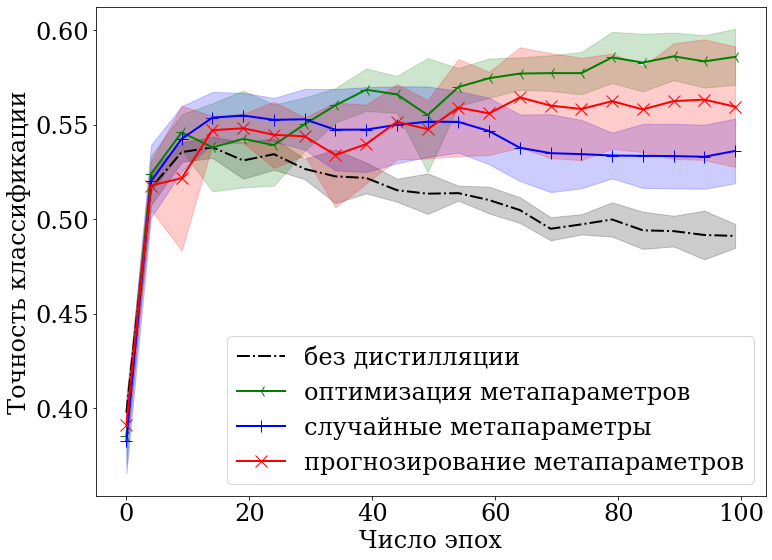

In [4]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b[:21], acc_b.mean(1)[:21], '-.', color='black', label='без дистилляции')
plt.fill_between(epoch_b[:21], acc_b.mean(1)[:21]-acc_b.std(1)[:21], acc_b.mean(1)[:21]+acc_b.std(1)[:21], alpha=0.2, color='black')

# epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
# acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
# plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
# plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-3', color='green', label='оптимизация метапараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-+', color='blue', label='случайные метапараметры')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_dr.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='blue')

epoch_s = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_s[2]['results']))])
acc_s = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_s[0]['results'])) for subdata in data_s]).reshape(epoch_s.shape[0], -1)
plt.plot(epoch_s, acc_s.mean(1), '-x', color='red', label='прогнозирование метапараметров')
plt.fill_between(epoch_s, acc_s.mean(1)-acc_s.std(1), acc_s.mean(1)+acc_s.std(1), alpha=0.2, color='red')


plt.xlabel('Число эпох')
plt.ylabel('Точность классификации')
plt.legend()
# plt.savefig('acc_'+experiment_version+'.pdf')

In [ ]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
epoch_b.reshape(41, 1)
epoch_b = np.hstack((epoch_b, epoch_b, epoch_b, epoch_b, epoch_b))
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.scatter(epoch_b, loss_b, color='red', marker='.', label='без дистилляции')
#plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
epoch_d.reshape(41, 1)
epoch_d = np.hstack((epoch_d, epoch_d, epoch_d, epoch_d, epoch_d))
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.scatter(epoch_d, loss_d, marker='d', color='blue', label='оптимальные гипепараметры')
#plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
epoch_dr.reshape(41, 1)
epoch_dr = np.hstack((epoch_dr, epoch_dr, epoch_dr, epoch_dr, epoch_dr))
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.scatter(epoch_dr, loss_dr, marker='x', color='black', label='случайные гипепараметры')
#plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
epoch_h.reshape(41, 1)
epoch_h = np.hstack((epoch_h, epoch_h, epoch_h, epoch_h, epoch_h))
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.scatter(epoch_h, loss_h, marker='+', color='green', label='оптимизация гипепараметров')
#plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')
plt.legend()
plt.savefig('../figs/scatter_plot_loss.pdf')

In [ ]:
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
all_results = list(acc_dr) + list(acc_h)
max_ = np.max(all_results)
min_ = np.min(all_results)

colors = [cm.seismic((r-min_)/(max_-min_)) for r in acc_dr.flatten()]
temp_dr = np.array([subdata['results'][i]['temp'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
beta_dr = np.array([subdata['results'][i]['beta'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.scatter(beta_dr.flatten(), temp_dr.flatten(), marker='d', c=colors, label='случайные гипепараметры')

colors = [cm.seismic((r-min_)/(max_-min_)) for r in acc_h.flatten()]
temp_h = np.array([subdata['results'][i]['temp'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
beta_h = np.array([subdata['results'][i]['beta'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.scatter(beta_h, temp_h, marker='x', c=colors, label='оптимизация гипепараметров')

plt.xlabel('beta')
plt.ylabel('$T_0$')
plt.legend()
plt.savefig('../figs/scatter_plot_beta_temp.pdf')

In [ ]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b[:21], acc_b.mean(1)[:21], '-', color='black', label='без дистилляции')
plt.fill_between(epoch_b[:21], acc_b.mean(1)[:21]-acc_b.std(1)[:21], acc_b.mean(1)[:21]+acc_b.std(1)[:21], alpha=0.2, color='black')

# epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
# acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
# plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
# plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-', color='green', label='оптимизация метапараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-', color='blue', label='случайные метапараметры')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_dr.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='blue')

epoch_s = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_s[2]['results']))])
acc_s = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_s[0]['results'])) for subdata in data_s]).reshape(epoch_s.shape[0], -1)
plt.plot(epoch_s, acc_s.mean(1), '-', color='red', label='прогнозирование метапараметров')
plt.fill_between(epoch_s, acc_s.mean(1)-acc_s.std(1), acc_s.mean(1)+acc_s.std(1), alpha=0.2, color='red')


plt.xlabel('Число эпох')
plt.ylabel('Точность классификации')
plt.legend()
# plt.savefig('acc_'+experiment_version+'_color.pdf')

In [25]:
epoch_s = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_s[2]['results']))])
acc_s = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_s[0]['results'])) for subdata in data_s]).reshape(epoch_s.shape[0], -1)
max(acc_s.flatten())

0.5960999727249146

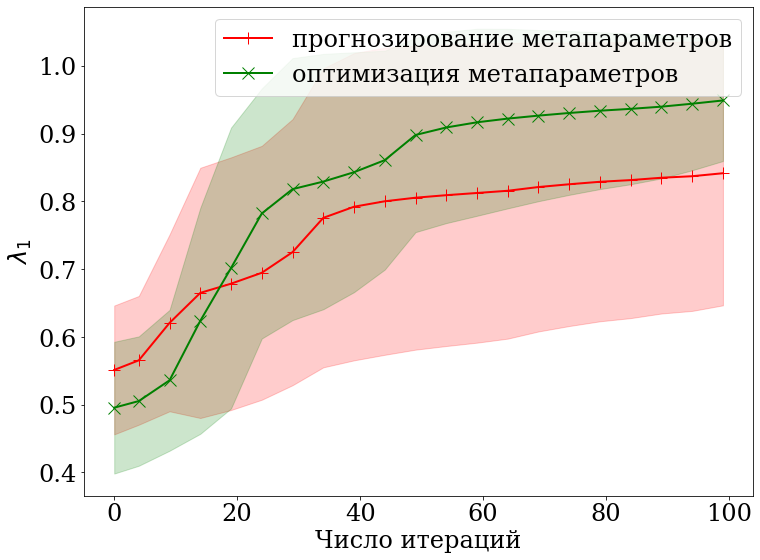

In [7]:
def plot_data_params(data, s, label, color, sign):
    e = np.array([data[2]['results'][i]['epoch'] for i in range(len(data[2]['results']))])
    par = np.array([subdata['results'][i][s] for i in range(len(data[0]['results'])) for subdata in data]).reshape(e.shape[0], -1)
#     par = np.array([data[2]['results'][i][s] for i in range(len(data[2]['results']))])
#     par = []
#     for subdata in data:
#         tmp = [subdata['results'][i][s] for i in range(len(subdata['results']))]
#         par.append(tmp)
#     par = np.array(par).reshape(e.shape[0], -1)
    plt.plot(e, par.mean(1), '-'+sign, color=color, label=label)
    plt.fill_between(e, par.mean(1)-par.std(1), par.mean(1)+par.std(1), alpha=0.2, color=color)

plot_data_params(data_s, 'beta1', 'прогнозирование метапараметров', 'red', '+')
#plot_data_params(data_dr, 'beta1', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta1', 'оптимизация метапараметров', 'green', 'x')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\beta_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/beta1_iter'+experiment_version+'.pdf')
plt.show()

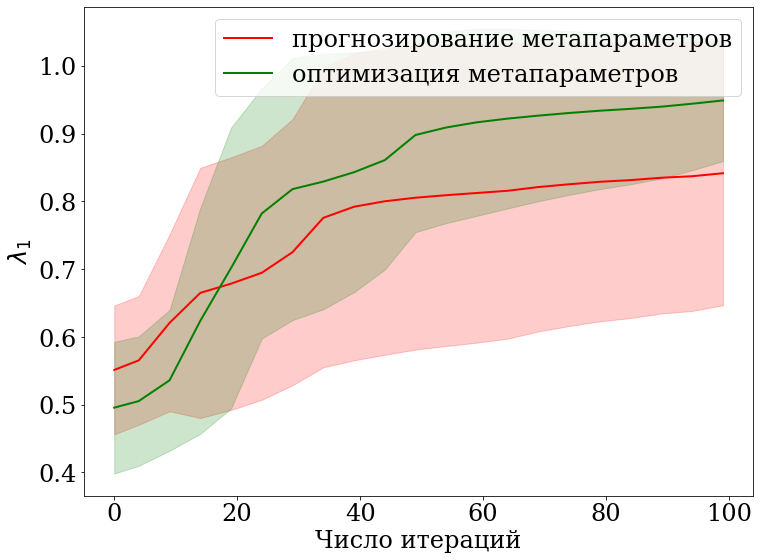

In [12]:
def plot_data_params(data, s, label, color, sign):
    e = np.array([data[2]['results'][i]['epoch'] for i in range(len(data[2]['results']))])
    par = np.array([subdata['results'][i][s] for i in range(len(data[0]['results'])) for subdata in data]).reshape(e.shape[0], -1)
#     par = np.array([data[2]['results'][i][s] for i in range(len(data[2]['results']))])
#     par = []
#     for subdata in data:
#         tmp = [subdata['results'][i][s] for i in range(len(subdata['results']))]
#         par.append(tmp)
#     par = np.array(par).reshape(e.shape[0], -1)
    plt.plot(e, par.mean(1), '-'+sign, color=color, label=label)
    plt.fill_between(e, par.mean(1)-par.std(1), par.mean(1)+par.std(1), alpha=0.2, color=color)

plot_data_params(data_s, 'beta1', 'прогнозирование метапараметров', 'red', '')
#plot_data_params(data_dr, 'beta1', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta1', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\beta_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/beta1_iter'+experiment_version+'_color.pdf')
plt.show()

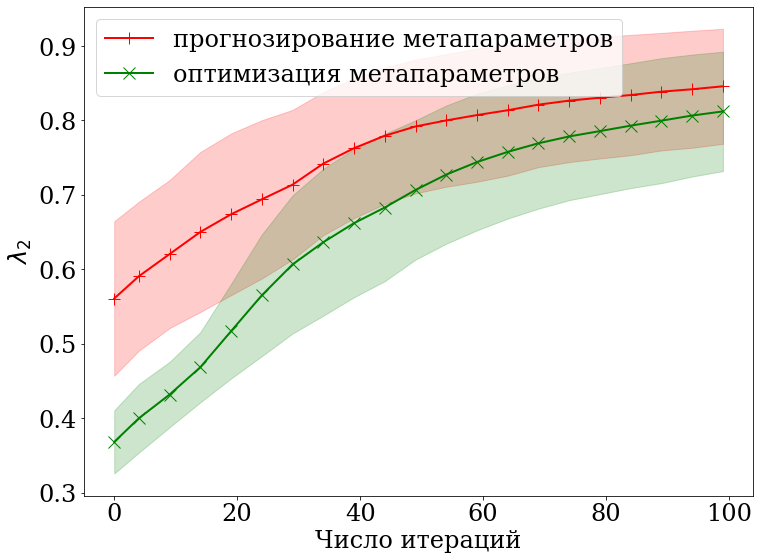

In [8]:
plot_data_params(data_s, 'beta2', 'прогнозирование метапараметров', 'red', '+')
#plot_data_params(data_dr, 'beta2', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta2', 'оптимизация метапараметров', 'green', 'x')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\beta_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/beta2_iter'+experiment_version+'.pdf')
plt.show()

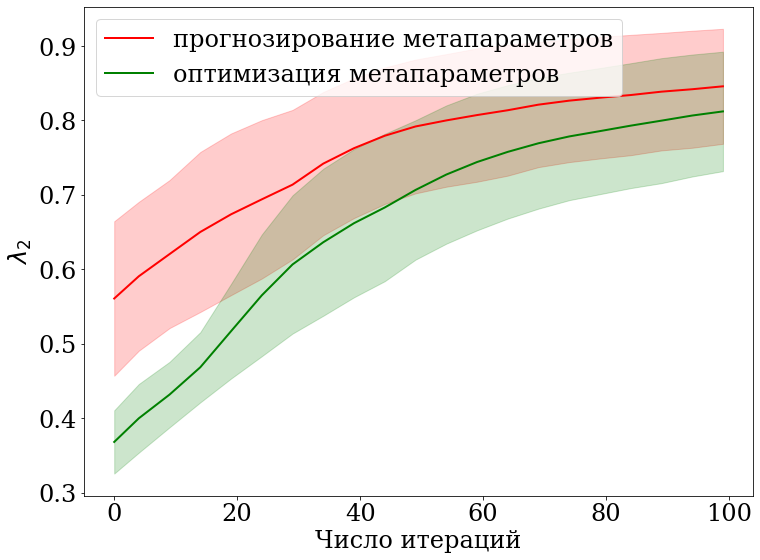

In [11]:
plot_data_params(data_s, 'beta2', 'прогнозирование метапараметров', 'red', '')
#plot_data_params(data_dr, 'beta2', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta2', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\beta_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/beta2_iter'+experiment_version+'_color.pdf')
plt.show()

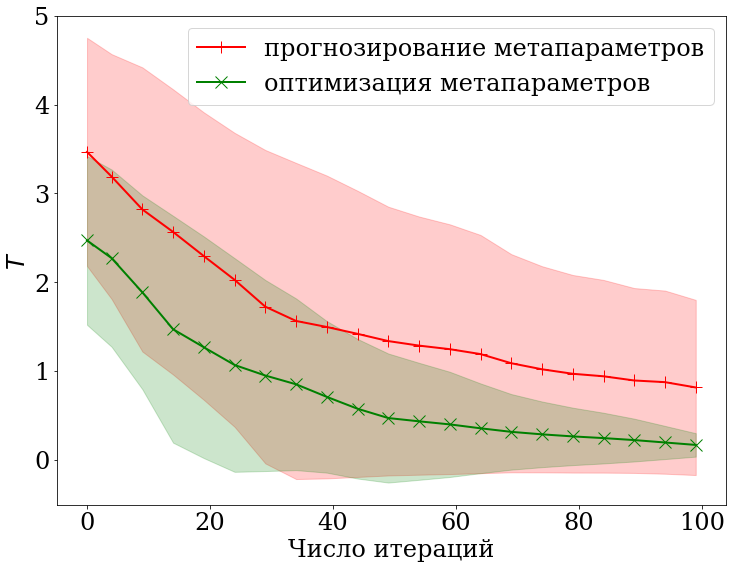

In [9]:
plot_data_params(data_s, 'temp', 'прогнозирование метапараметров', 'red', '+')
#plot_data_params(data_dr, 'temp', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'temp', 'оптимизация метапараметров', 'green', 'x')
plt.xlabel('Число итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/temp_iter'+experiment_version+'.pdf')
plt.show()

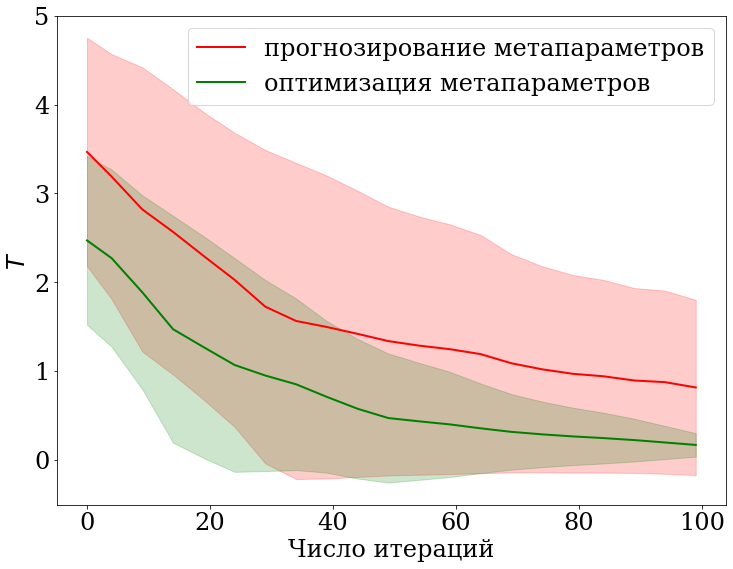

In [10]:
plot_data_params(data_s, 'temp', 'прогнозирование метапараметров', 'red', '')
#plot_data_params(data_dr, 'temp', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'temp', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/temp_iter'+experiment_version+'_color.pdf')
plt.show()